# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


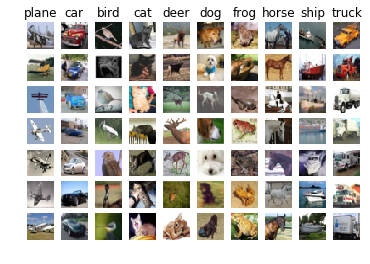

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]
# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


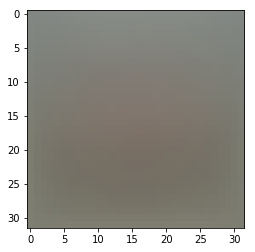

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 
#print('y_dev.shape:',y_dev.shape[0])
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.533059


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 7.367999 analytic: 7.367999, relative error: 1.169893e-11
numerical: -3.212021 analytic: -3.212021, relative error: 1.242952e-10
numerical: 2.077908 analytic: 2.077908, relative error: 5.892030e-12
numerical: 7.853007 analytic: 7.853007, relative error: 5.979523e-11
numerical: -13.101891 analytic: -13.101891, relative error: 2.355563e-11
numerical: -13.107917 analytic: -13.107917, relative error: 2.252917e-12
numerical: -6.009699 analytic: -6.009699, relative error: 3.987766e-11
numerical: -39.418736 analytic: -39.418736, relative error: 6.585709e-12
numerical: -5.559359 analytic: -5.559359, relative error: 6.124991e-11
numerical: -5.635433 analytic: -5.635433, relative error: 8.197824e-11
numerical: 2.988846 analytic: 2.988846, relative error: 7.441494e-11
numerical: -0.745526 analytic: -0.745526, relative error: 6.891068e-11
numerical: -31.242388 analytic: -31.242388, relative error: 1.116085e-11
numerical: -9.486183 analytic: -9.486183, relative error: 2.583991e-11
numeri

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*
f(x) = max(0,x) is not differentialble at x=0

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.533059e+00 computed in 0.265588s
Vectorized loss: 9.533059e+00 computed in 0.105786s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
#print(grad_naive[1,:])
#print(grad_vectorized[1,:])
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.276903s
Vectorized loss and gradient: computed in 0.017187s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [16]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

[34039 16594 21418 44802   374  7119 25703 30966 45336 31335  5677 25620
  5712 46811 10625 23461 24643 30238 30553 41679 38393 46757 15162  1990
  1708 25137 17503 11746 19528 13314 19575 33152 26903 16231 25606 22614
 22468 44371 28361 26885 38485 22485 16516 19795 33509 44396 42414 17018
 35989 34715 45113 29078 31884 26056 29324 17986  3806 24641   401 31638
  2431 28928 28186 33357 19877 16950 17006 25379 36039 24130   672 44495
 20029  9994 16141 22196 43381  5348 16850 15206 16830 36511 27156 32803
 14607 15631 36184 14101  2227 30477 42263 26654  9827 29353 25107 37005
 13798 28083  3649 11122 40513 32719 48638 19099   753 35784 17428 41819
 22150 39919 36334 47692 36495 44658 43999 16099  6033  2541 20912   737
 25709 44014 23816  2384 16626 21105 30452 30043 48694 42134 39989 32154
 16552 15442 40804  1902 26870  9408 43008 47276 23087  3999  8731  8029
 44614 30112 36686  4717 18000 37959 25024  4730 43147 36461 27441  8693
 10995 33137  3315 18739 25112 44322 24469   768  3

[43299 30856  6624 47357 48330 24872 15218 35006 12795 34679 41258 27518
 15489 24799 29033 11733  9157 45293 47648 24658 15428 11360 30280  2713
  8542 19893 46815 48862 19463  2746  6095 15847  7616  6271 39924 35244
 32534 42718 44957  9690 35739 28289 21142 14143 10779  7360 15388 44347
 41293 25434 34160 10744 36190  4724 23616 45410  9455 48770  6750 10568
 16014  3503 43088 18932 29834  5536 45104 20712 12711 48124 44500 31524
 44110 32626 33417 25364 26956 22049 18149 37494 16895  4421 14512 42014
 24379 22869 19019 20747 13696 11004 48817 20087  1681 35682   894 30096
 37848  5547 12945 24208 32544 16208 21353 40829 48160 36922 18310 36852
 37759 38560  1091 22116 16627 45624  7766 17057 37245 13182 45446 44180
 24187 27644 44000 12165 32566 24839 29481 15157  5873 45391  4459 17510
 27809 17868 12869  1229 32089 44384  3286  5707 31630 20058  9942 45615
 37816 25282 31655 20272 10499 29465 35641  7776  3483 44210 47507 14001
 18824  1904  7048 16260 46251 17766  8975  7470 37

 13083 46535 40241   855  9088  7629 36689 11742]
[27178 45549 46070  9140 46740 27825 30376  5165 13038 11374  9538 16420
   213 22462 37191 36508  3367 25442 28695 22142  2134 15669 29832 26370
 42418 21417 35667 25358 47187 12812 36126 38783 10680 45989 41417 18635
 26843 42962 38080 17859  9299  6573 10216 32780 18837 45916  4646 14774
 10035 19789 26929 17542  6343 34449 20937  1729  7153 11953  2013 42962
 23074 35992 39804 47445 26735 43082 15127 12118  6734 48715 36276 39849
 29530 39996 48447 13912 45791 15455 34470 22270 25904  4554 22018 15578
  2084 40355 16127 43114 14168   601 27463   424 18816 28668 21715 38456
 27032 40660  3686 35599  9358 14399 47296   283 38548 35741 17764  9435
 20057 26508 29500 13985 21229 14863 17551 12370 41204  8479 16941 23427
 30374  7388 46492 37836 40577 17019 48627 15255  2760 21206   420 30516
 28309 12599 32030 23100 33082 20395 12760  3182 37449 48747 45629 48416
 26555 31713 44430  1932 45697 17613 33529 18242   870  7905 28845 13829
 

[27685 47198 24079 15722 10523 45008 11961 14024 33745 11477  3664 23428
 33303 31493 46651 48254 48097 11945 21672 12013 21731 28132  9703 44238
 41220  9128 34501 45622 22896 38808  2123  2973 45337 12559 12445 29795
 13695  7037 25614 32465 42269  1122   780 46751 21509 37484 21049  8592
 36696 36845 37861 22899 24423 32907 19669  2659 41575    61  7947 33212
 41489 15622  4002  5044 27594 36133 18845 17959 37846 46232 28865 14661
 28766 29759 11943 40624  4393 39210  3886 11808  3432 29952 38050  5810
 42316 19425 34971 20146 11209 10806 36526  3486 20332 27038 36380 10140
 29357 19941  9940 20654 16030 27050  1634 22778 44106 40635 40841 23481
 19325 32198  5229 35455 15143 23306 18095 33416 36760 43185 13041 22966
 18535 45216 48138 24619 28297 44673 24053 40118 24024 36930 22977 27724
 23427 11047 22675 11847 13815 39130 29717  6298 36867 38472 18528 28042
 13473  4957 40734  5993 46510 34104 46896  6142 26989 17286  2448 18252
 16373 12617  4137 20492 24837 38518 28877 43738 40

[ 3379 46841  4913 30106  4409 10795 23203 27758 14891 45184 36716 45150
 25427 46696 40180  1694 43408 31671   267 10956 19009  1168 12639  6610
 21133 30873 41773  5168 29376  8387 38874 40560 39323 15156 15296 40342
 33624 33563 16981 23795 17237 27208 34329 32816  6881 25833  6333  8759
  7346 29841  4640 30381 46186 40802  5653 15928 30783  6717  5207 30017
 40002 35860  4462 37902 29959 36295 32740 40415 35654 34529 17485 45014
 27620 30005  2997 44529 26057 45124 34823  4670 42973 36508  9286 11621
 34199  7498 37802 15744 27825 47811  7116  6109 48183 16369  8476  3643
 36918 27452 27372 43431 33628 17160  9244 31809 26517 48873 40742 40096
 20467 38844 18679  9708 36091 25278 29342 21088 17653 24304 24170 15394
 40856 38558 15971 35161  7147 48774 48580 20369 48607 14723 24192 18606
 35602 22241 16015 38854 28220  4735 40451 46509 31057  7754 24013 41710
 45927 17607 14828 11173 40580 31708  6070   673 36248 41132  2357 19697
 29365  7800 25433 40426 38116 46434 13708 45948 22

[25592  3911 36068  4496 25563 31803 37684 44566 46085 30888  5086 46431
 46189 41245 47419   596  2640 37072 19850 45840   372 31478  8435 14387
 15327   943 15766  5611 43482  3138  6429 25546 21227 32603  5498 10495
  4929 15047   409 27697 12695  7486 24842  1817  2086  6323 37626 37739
  2044  6522 28889  4929 48043  2050  1097  4614 27336 32938 44290 42806
 39183 46765 28608 14379 36248  6604 26613  1564 21102 28010 14921 32401
 44070 36296 25559  7491 14203   219 18067 30431  9480  9574  3986 26844
 11085 48709 43820 41379 13651 36847 14570 15011 39772  2877  9919 38027
  5500 13338 46660 36364 43566 15844 27611 15663 31626  3138 48105 38163
 45763 26626  3938 28676 10988 11789 39880 43742 31426  6060 26941  4080
  3138 41172  7957 19547 24393 29752 48506 42159 32608 36493 33803  8535
 19625 28057 28700 25246 20556 37102 27912 26702 42012 38354 18201 11583
 22649 34728 21533 19949 10749 45062 39704 25641 29999 32043 41384 14569
 43782 46042 35329 42393 35694 45939  5469 33591 20

iteration 100 / 1500: loss 285.512377
[ 8396 11804 33920 24558 47417 34230 11538 40608 13435 27073 48135 34886
 40860 17122 20545  9917  8152 13281 32096 47529 31670  9034 25286  6260
 22370 34056    95 40012 29599 13101 19400 42512 43302 41975 45924 23236
 14499 24343  1989 43211 23872 29079 37276  6524 25200 44717 20240 37320
 31239 36623  1021 38520 18848  6726 16225 42484 38968 48785 37360 35341
 36610 20490 35254 20897   551  6674 28265 20185 41626 13344 15249  7341
 19342 14057 46851 39721 44859  7662 31546 32106 45653 43441 18080 19323
 30276 46740 48765 15220 25359 43873 30230  7618  1191  9989 18142 26647
  4669 39833 31853 35950  4164  7653 11472 28344 27884 40465 36115 41617
  2317  1548  9374 33287 42619  9384 35714 29829 44764 29449 45781 35351
 40803  8503 30091 16502 12266  2262 16166 18611 22670 27597 39934 29974
 23375 21152 44129  6607 27507  7118 17952 41121  3954 43100 17124 46394
 22935 32892 29858 21070  8501  6216  7093 12275   811  3222    91 30174
 32332 40741 

[ 5666  3133  1616 14905 40780 25016 33177 20924 43678 29556 15985 45856
 38200 37742 11096 41438 22201 45946 17975 43936 40970 17269 26283 24659
 40457 25770  4258 42327  4067  2885 31937 39146 28442 32608 14773 32967
 39454 47536 24166 35940 27415 30751 14383 14301  9547 28367 41693 25350
 33383  2377 30598 13012 38390  6173  6295 10503 28754 27140 42630 22494
 41268 38130  6258 34031  7211 16986  7516 39376  2049 22073 30900 39237
 28152  8512 33767 46318 12268 25604  7971 18220 13558 30214 11151 40705
 32749  1356  6494 45873  7526 40358 35977 43503 18902  3570 44878 39931
 45075 35062 30011 18918 43225 32073 48183 44805 21504 15072 36784 19923
 42466 22487  8564 13326 48285 13072 11224 41001 45570 27505  9809  7622
 15041 16538 28018 45429 39174 18070 10214  9915 29988 28286 34435 37937
 10841 13206 41409 21291 20079 42694 48357 37442 32483  3559 21712  9910
 10564  1100  4879   664 17015 47816 26564  9211 17797 25275 40122 42760
 12364  3297 20324 47693 36802 16589 27293 35736 13

[30645 19285 44065 23802 26216  9490  4685 21586  6196 14512 47685 27667
 17143  6933 15430 29136 41226 18564  1596 40232   402 45662 40003 22555
 22200 30708 41975 43123 24804  7627 45238 13162  8499 21443 39498 30281
 38974 17977 22896 39210 12072 45352 32465 28526 27362 43146 18798 38613
 24351 29183 40681  2472 17515 24218 40806  1856 25566 40402 40234 13216
 32051 33501 21418 38236 34588 17089  3341  1715 27166 37872 30823 38157
  3850 13533  2530 19149 25374 12093 29338 43367  3033 37430 14995 31999
  1217 35271 46743 10779 33682 13623 34505 19471 29102  4630 40397 41490
  8058 17362  9527 37585 38872  2796  6715 40846 31457  7240 37153  5976
 32410 40256 25030 24860 31717   946 15696 13845 47971  3464 44862 42482
 45719 30351 24331 42187 32201 38921 14516 40539 22461  4807 32261 46466
 47397  7423 23954  5565 38142 27806 25365 18145 39332  3162 22280  4841
 43319 16936 33469 46861 17301 11104  9084 19931 28072  4560 47249 20774
 26398 38014 18702 13476 47500 12763 18698   629 10

[16014 40946 19465 38817 28724 32550 32233 38271 46458 15317 48310   451
 35940 22400 31136 47748 35962 12021  7395 24997  6831 12465 16345  8182
 21890 33152 39295 31462 47959  3623  7241  7417 16503 24650 23662 12714
 11576 14223 42312 38256 10974 15080 22592 16064 46917  5388 41291  1912
 15690 47291 32599 25461 22009  3889 38813 14961 10952 24999 26338 13824
 23935 25951 48172 21365 42807 44451 36172 47098  8942   245 39506 29178
 45901 20637 47639 18292 13601  7070 14708 17641 35685 32905  9888 43132
 24317 18628   958  2714  4259  9778 32974 15626 23425  2084  7633 18358
 35167 10461 11272  3982 18776  3368 36071 27865  5926 24541 11490  8924
 34502 46544 27925 27661 37907 29006 36982 19135 13668 45512  2206 13816
 23178 16889  5421 28804  6937 30340 12815 26350 40207 22839 19164 27883
 38784 40857  9302 13482 10672  4530 20644 28836  2353  8210 10556  9937
 34242 34366 35507 11054 27048  1142 47850 16079  4511 23205 19464 13885
 15411 17288 42406 20866 27128 10842 21776 37180  5

 10731  5225 22231  5741 17918 23814 11399 46394]
[44815 26246 47285 22563 21877  7386 32781 12598 20832    37 27574 24355
  4166 13230 12358  2191  7699 10423  3284 35827 35670 48049 26108 15413
  9275 29939 12546 29719 15299 20005 21405 40876 15379 22669 36965  1174
 28550 35805  3395 12767 18919 21087 30894 15300 21051 28105 36313 15382
 31690 40957  9315 20023 21399 37557  9268 22951 41426 13887 11893 15637
 12161 44276 15358 13103 17579 38405  5208 38998 19872   115 28240  9530
 27303 25978 17442 15454 11536 13933 12449 39051  3842 24111 35096 10054
 29691 45000  6975 25146 32242 20297 38940 20590  1337  5421 16310 35939
  7065 21846   894 29135 24811  1581  6083 19680 16475 17320 32064 13162
 14457 13527 13568 30689 45693 42421 40304 48642 32921  6095  9631 19538
 19539 42615  6645 19762 36723 26626 40029 24452 25080  5287 21573 26764
 45136 37911 33854 27916 33801 24816 30476 21767 43803 13482 19813    94
  1546 38568 11245  4751 40293 31838   906  6199 48627 39587  9082 29666
 

[12442 45697 26147 18281 33610 31139 34244  2809 48254 23363 35616   114
 37057 26888 19252 31305 38396 18742 19581 39117 43673 32243 34139 25194
 48195  3808 44562 39723  4965 29759 29417  8806 31193 31749 28654 36937
  7961 13481 12985 21281 41720 33598 31109 28346 21231 22685 10105  1330
 34255  4394 21508  3668 34768  7538 34685 14603 30849 21588  3186 13744
 42292 29518 11210  9468 27799 26849 28559  1175 30075 11199 12735 47603
 36448 43838 24213 14606 12389 24268  3857 23930  7611 13431 19847 11608
 42452   731 18126 16345  2815 19393  1052 21339 40187 48173 14470 14520
 26481 21346  7942 22642  1035 33734  7149 48146 33892 21939 31819  1915
 21421 40307 16275 15819 39515 45924 45944 44840 43238 17814 25690 25482
 44114 12549 31684 24219 37230  2580 37567 32992  3025 30860 14537 20199
  3806 33382  9839 27591 18224  6257 19855 44054 10215 22898 39700 19117
 13812  8627 41188 38305 35356 39311 22973 26728 43244 42650 24760 20987
 37464 45157 21864 11401 33870 18004 31882 31081  2

[ 4050 34938 33308 15122 15268 31308 42112  8591 45019 26312 23609 24572
  6435 25971 45361 28798 11064 13404  6058 27553 20972 30078 48818  6478
 23676 48897 46435 19838  5006  9180 39772 48716 29122 35908 44572  1783
 45865  7484 37578 23727 13271 44139  7204 46511 35755 25325 34613 32460
 29407 11663 18490 27440 35896 40439 18541   533 47176 39678 12844 29572
 31648 21012  4818 18973 40120   210 18447 16799 33345 19100 36250 28118
 20933 40747 39210 25579 22860 44692  7461 15904  6685 36714 46604 25274
 45169  5769  9337 17625 24171 21456 10314 47755 46013  6404 13699 44264
 17206 21267 21837  3204  6696 46225 30522 31527 45646 18407 23861 43691
  3449 23341 40271 11280 18769 15492  3055  7127 39426 40332 25489 14968
 29521 19680 15518 12554  8464 24774 17543 10417 20343 12039 26730 43573
 45098 44376 30116 15632 27317 44781 31067 14457 21020 35760 11932 27944
 31436 43789 46073  2755 11667 40689 31240 12030 20479  6571  1632 45872
 43286 11844  1577 20989  8837 12283  3059 12840  7

[33958 19407 39372 12381 21043 13245 20817 19962 34512 27173  3688 11469
  1730 35113  3142 34447 32461 21231 13758  1793 10811  6508 39276  5668
 33829 22247 30576  7565 38073 25611 11353 29940 37879  3157  4331 41791
 39432 18495 31232 45197 18335 10302 19731  9741  5122 44429 18691 42446
  9795 36489 33854  5600 44472 14816 43985  3679 28859 39235 41964 45775
 11005 24962 19132 45647 24892  8958 32292  4183 31681 24310 18911 45270
 14433 39538  3109 27795  2455 21181 18524 34617 26758 25651 42179 29135
 37760 14272   279 24475 36819 36654 19386  8753 39434 32269 19583 17184
 12585 38597  2293 35163   640   101 29160 10309 19864 45703  6570 41682
  2216  6876 32511 27698 31834 24376 27212 10075 19448 30732   628 25134
 12860 12214  1097 42959 14696 12862 16906 12814 29130 12885 13235 36835
 13162 22866 35353 48224  1503  1674 16796 30564 47175 34420 39177  2779
  3937  2612  9071 45381 27820  2190 15251 19284 14767 14068 24697 28157
 23394 21766 18854  8409 27856 24642 11482 43379  7

 32304 47177  8586 18434 15873 45642 32649 38744]
[26670 20354 22972 16442 40347 16171 11002  1775 35692 46268  4381 32936
 39189 43322  9880 32058 10224 46866 31698 28866 30594 21193  7001 27761
 14487  1920 13808  3847 23873 13016 21694  3468 28859 44392 25568 37650
 46685 14561  4912 39494   564 14795 33791 20028 39296  7264  2821 48001
 44405   120  3210 11076 40015 18528  5077 47224 25818 13260 26246  3897
  5377 34270 40023 22805 18744 37823 47916 33559  2909 33864  9500 40095
 33622 32472 38659  6156 16958 31868 24441 37527 26726 21967  5480 25316
 12808 48259 36790 41871 14686 14652 44286 47333  8711 48298  7129 30668
  9029 48294 29867 44957  3994 21904  2262 11457  2637  9909 15208 27987
 44847   492  1266  3690  9919 14182 19623 46705 18310 42194 11044 25231
 14453 18142 11302 29164 47714  7431  4776  2221 15813 15269 21664 47344
 42928 17109  8661 40355 46977 43178 37207  4471  5916 42716 46052 22815
 43467  8586 23247 43820 32976 45935 16171 45411 23530  4868 41099 10426
 

[16096 33354 10110 24123  3447 32252  7301  6591 12192  7075 21591 20344
 39691 33236 25288 45370  5279  2027 36537 29904 15143  3118 34840 29080
 32926 39775 27297 18831 40292 15244 12875 13023 25580 26131 14252 17170
 48931 20386  2800 22385 45707 17540 25869 23793 39154 11304 19435 23073
 21935  2060 42118  5481 34649 47393 26801  5626  3739 31526 44202 24968
 19550 44191 24104 25610 17618 31982 22413 11670 32733 43502 31785  1425
 35859 14679  1823  7179  2122 14636  7826 26334 21938 41343  7174 12634
 25670 28246 15727 25512 32138    28  7412   910 17436  1574 34317 48850
  6950 23533 13124 11178 36819 46873 19957 48987 41015 35864  7455 23923
 23980 38268 10707 22210 38059 34047 48554 14266  6633 13603 13394  5331
 39661 18415  9787 40460 37834  8555 19778 45305  8849 30833 47746 13304
 10130  2527 20985  9354 20797 26558 27859 36052 17139 25384 12758 33511
 40371 33840 35922 45891  3846 20941  4595 21856 35276 24985 40985 42469
 25224 37140 22246 39973 43586 40682 48140 43508 23

[14318 26887 10382  1866 11796 48279  3234 35827 39745  7992  2437  8765
 29192  6762 27799 17821  7370 33759 42684 40197  1484 43147 14472 12920
 32252 33275  2695  7085 32274 18381 34009 29019 22230 47016 26933  7052
  8712 18034 12358 11949 20824  2148 29338 31024 19460 15892  6802 43547
 31407 37589 17719 20143 11493 47666 29600  2486 45674 27731 33848  5406
 30475 25581 34271 48683 43791  9482 40709 27024 40700 19508 47134 37133
 44860  6060 10742 12095 10512 38971  5371  1597 26845  6941  7230 18300
 17550 13662   748 36722 10844 28170 33565 11989 20338 48414 11621 47880
 26908 18746 14450 13988 11153 12066 36280 10962 37449  7864 48084 42926
 24017  6905 13357 14962 25444 43691 47027 43391  3284  1534 35208 17776
 37637 33056  5237  8906 15739 16076  1791 24012 21316  4753 47969 35952
 45537 33428 31463 29807  5676 33538 18849 26806 15333 10676 13825 20183
  2509 28449 19499 25315 44789  9285 25716 18567 29420  3675 34840 12370
 16757 30024 22273 16400 43993 34556 15372 48305 23

  7044 33842 44332 18402  7909 33699  1667  7441]
[12394 35838 47479 15248 38083 19625 12127 28755 25074 31319 31353   229
 34801  2040 31741 36107 42141 15353 34269 43400  5613 13350  8119 10516
 37823 16484 29695 11329 32676 22927  9933 40132  5783 47157 20903 29218
 21494 45922 32396 13034 30204  2393 36822   946 31184 35338 30173 37362
 35422 11763  9159 46924  3461 19567  7760 20588 32852  8625  2698  6778
 39324 41666 12334  8765 16051  3209 47687 30704  9222 22234 17961 41025
 48632 21702 12713 23043 19722  6938  7887 47383 14417 20694 13878  1259
 21308 15592 42642 27663 15972 44955 17060 31300 42632 37131 24883 43398
 21119 15158 17819 23526  5500 32115 16087 46617 32878 39776 35527  5487
  4706 28434 29139 12144  9636  5841 48244  4821 39422 36139 44313 38951
 40166 45517 26624 10792 22671 32801 18119 45266 30607 20562 34529 48028
  3742 24778  2227 23918 41004  7191  1428 31098  3727 30816  5865 32510
 48117 26398 18752 13231 41879 43238 41313 19019 45357 24657 11740 43159
 

[ 7423  1140 34796 17216  8488 24626 28261 17697 11053 25912  8709 29028
 15382  1363 38398 46183  3272 24566 45111 21438 41571 43351 19800 21864
 30097 19782 29813 15975 39714 48685  3337 34872 46225 45262 20027 30683
 29200 15672 12272 23851 25063 45798 36011 43454 41178  9002 10047 13454
 48281 10273 16858 10252 34262 24072 36404 34725 20590 27427 10027 38499
 47219 21739 27833 31592 44950 22009 28145 26375 30769 23447  5052   265
  2191 34395  9730 48603 27386 39874 45753 26104 17363  8115  2526 30911
 10434 39999 44247 37786 37395 21661  6874 30801  6222 29165 21620 13609
 19462  4351  9896 42864 12235  5611 19888 43726 41426 39430 12116 13895
 34842 33441  9352 28259 45448 44574 27011 21718    44 16582 39527 18980
 43187 46092   468 30687 37507 45647 30792 17202 47056 16553 26427 28309
 13340 13874  9581 31011 32640 12396 35511 33668 48578 18912 35331 30238
   432 27671 47721 12290 35813 42312  3866 23665 41734  9555 28636 33016
 24145  1834  5771 19500 43642 46119 12029 15778 23

[48855 34627 12239 12650 44633 23432 35468 13433 14181 13516 25320 28502
 34959 48973 39704 43366 43395  6974 31051 45470  8222 24784 26899 33105
 16133   183  5986 23680 35561 14622 10546 15165 29975 31563 26488  4656
 34392   926 29055 29440 46651  9073 25986 24854 41506 26509 13986 22007
 22165 14203 36771 17581 31313 31314 27022 13475 33840 48077 23013  9278
 42114 10607 14531 39099 12535 47695 14642 43104  6756 12933 29762 31177
 38934 31505 40819 13755 36093  8893 33740 28918  1043  4134 45915 45592
 36655 37444 24876  7489 28540 42079 27215 46675 22087  3667  8999 33822
 19174 13886 24837 21782 19459 12189 25455 39768 20972 14821 28855 22885
 45966 19932 33775 36036 39679 44176 14781  5685  7941  6556 38437 13572
 44122 34379 17825 23027 45324 31232  1077 12461 17975 41567 43208 31392
 17720 43362  5372 14103 43338 47852 22381 16657 28871 23727 26129 15254
   434 48135 48896 31941 35013  9251 29686  7642 42011 23666 29818 14964
 36597  3689  3578 22176  5432 31279 17341 36999 31

[42497 37653 38437 47694 27132 18559 14526 20063 46373 36212 31019 42852
  7215 28293  6137 41571  3465 36261 25707 40046   677 14733 22392 37110
 21502 37730 35201 39729 23253 30851 17312  9421 45303 46416 48455  9253
 17273 35016  5916 19217 42125 45888 48291 42452  6026 30429 18665 46903
 35176 37567  7063 35443 14071 27345 13100 44904 22667 20662 12525 14778
 30369 10093 44912  6736 19574 12579 46833 46628 41827 25636  8736 32004
 34741 29360 15968 36210 15753 23451 33933 13465     4 37775 10669 43794
 31619  8368 34637 23405 26752 41114 22863 19567 26969 38529 32950 10727
 39726 28870 15516 47057 20976 19075 20744 43646 32219 28683 15856  9269
 26294 39492 25154 10645 25575 44173 28757 29974 10785 11144 24096 47485
 11915 32622 32445 44027 30682 39130 19662 12503  8574 10806 13758 22338
 37580 28978 26876 13117 31269 43566  8169  2370 15012 24723 48687 17595
 47175 30256 39268 35967  3927 17647 33302  4888  6877 31645 47096  5865
 38994  5664 34793 21182 29816 10061 28211 30873 12

[15757  9847 21058 25449 18105 41072 47174  7743 47345 20066  4733 19947
  1994 36373  2043 36276 48273 11310 33107 36529 19863 27169 27948 35177
 46100 13842  3228 34208  3445 10288  3628 48154 24838 37639 37572 47860
 21788 34525 37821 45362 48048 45298   253  4145  5030 26575 15622 16889
  1246  3642 11595 21577  7943 30143 14532 30299 10055  4775 36060  6927
 13363  7913 18317 30033 29473  6917 28248 23487 42132 16811 43819 16383
  9587 31983 15519 10338  8226  5001 31837 40518 26575 42737  5726  9612
 41156 10339 15427 45440 26728  2841 17190 36247 46360 18682   201 37740
 24047 34877 10653 22074  1201  5876 39385  2718 12039 43976 35940 41408
 36132 18710 39315 39135 20250 40983 44883 45401 19585 13685 26357 15067
  5178 13202  4738 45861 18545 30877 12788 13590 31838 44602 48783 21937
 32210 22761 34186 34245  7949 19142 13122 42088  8895  7611 16465 25344
 48831 47775 38957 32899 48197  6371 42682 18434  4935 12053 42761  6639
  6053  2035  2631 48895 42639 38629 38951 22731 38

[44512 22855 14340  6944 38242 11492 30881 28175  6671 24118  6601 10529
 46259 48081 34598 27800 36574  3408 15497 45565 21971 36418 22051 12080
 25946 39440 21797   765  5871  9406 24845 30913  2470 21888 33357 40248
  2886  1970 27844 38204  8086 40358 27433  4353 39406 28901 20020  5167
 38333 40926  1731 30274 43010   630  9501 16190 26741 16158  9494 36345
   887 22877 13420 42784 48809 46278  7394 21999 38448 38613 28083 44546
 22540 36673 14842 20667 19397 16074 18746 26398  9013 19394  3378 25200
 28044 14359 34530  7449 42004 24830   916 17381  7854 33872 29000  9163
 48535 39223 12681 33086 22030 33285 23457 26754 39903  2561 36349  9661
 21947 21696 20040 27963 39678  9502  3163   999 38756 20294 12649 30064
 43742 14672  1606 43219 41195  6610 12107  1710  4387 18792 46675 25204
 30904   409 47332 13621  1036  9858 16321 26343 35296  7635 35495 38421
  7567 31113 11514 43995  1464 28534 36386 31737 25263 16008  5319 14705
 17481 45322  7928 34043 26240  9968 32883 45160 39

[43070  7568 38689  4483  7708 17188 13239 42572 47183 45835 19515  9701
 30431  9548 40251 10061 46837 43409 46150 34280 10076 35074 39351 47370
  4250 28332 47070 29583 24430 43681 48657 27162  1179 10216 32767 17476
  4013  1085 17114 39961 16004 15124 23162  5747 18314 34961 42472 11253
  2866 19810 23776 15261 41889 41151 38677 42885 34865 17834 18289 32252
 15617 44911 23001 15500 31346  5574 43881  5054 33833 44889 26356 27147
 35598 22749 45603 11245 13630  4605 30748 37761 38029 41056 12770 47672
  1410 35851  1780 33220 22259 10897 20154 38200 46634  4955  4031 24985
 19153 39820 27043  7248 47027 15856 15477  6323  2985 37959 34840 23628
  4275 29447 24314   457 22236 34377  4638 39640 42289  4582  7302 20489
 43485 18552 15219 45159 40053 12600 31910 25356  5288  6949 47901 16987
  2715 46171 43709  9787 37031 33438 37750  9940 13322 44381  7893 20776
 28293 10797 26271  6199 45718 18292 26349 22867 40851 47033 32769 41138
 45074 45195 11794 47008  4273 28063 33245 23477  8

 38386 28941 10207 11947 19903  5547  6342 41907]
[48164 30153  4715  9831 47980 21740 36127 34218 40430   576 25362  4651
  9570 27296  8774 19900 44599 15581 32166  6528 40403 45262  1256  6677
  1892 21846 25984  8608 31153 14499 13726 13334  6208 39823 41515  9122
 28027 18591 36455 10507   578 27778 26517  3003 44347 41668 45255 22670
 22740  3402 44239 45013  7308 39646 20685 44631  7792 27447 48911 26571
 18834  6021 20479 23615 12219 11238 37046 35410 18511 35260 35376  3386
 33073 15664 27287 29521 42362 22575  3042 31762 18810 46922 12570 31631
 47370 46840 13921 26205  4542 32620 14533  6411 19550 13122 27391  7589
 11992 13720 21273 19392 22835 41432 28721 33618 39465 36082  4528 20746
 23239 12788 16030 12887 47026 41354 46009  9972 15293 31172  2864 44421
  6917 42861 14545 35970  8534 30221  7305 40671 12617 35664 24368 46667
 17049  1624 39215 39301 34230 35995 39317 19081 16457  5420  9582 11017
 18876  7707   421  2335 28409 33249 22056 21839 44820 33937 47363  6050
 

[ 3613 39531 22889 21215 32162 24361 22569  9133 36717 22177 12653 31907
  9221  3039 15650   349 25900 16940 41737 36088 40437 29225 27232 39424
 24256 26410 27225 42880 22734 29560  9863 33342  2571 20339 18694 22620
 10616 26074 26540 17571 12196 42804 17481 19460 39595 20683  4313  4885
 26137 21259 23089 12926 10314 40942 16222  7545 19103 24908 47755  6874
 33260  6277 25017 32308 35574 24724 16618 23197 21465  4464  8562  8253
 35550 43008 47848 42003 42415  3629   181 40673 18187  7000 22634 29821
 36651 24657  5885 12089  1352  4297  6091 46033 28216 31662 25058 22574
 48047  5423 10544 30472 29796 21410 11412 33951  9450 41097 41900 10775
 47146 45439 38444 30212  5469 47959  1550 34294 48167  7227 35802 12173
 39870 22881 48400  2940 43137  4008  7002 20906 30157 15634 41876 12601
  2374  6955 27425 46531 11670 15632   524 11704 21547 44422 27959 11383
 10596 27858 48086 36938  2699 47243 16117  2404 37411 32368 41070 43934
 47419 29865 19826 12396 43461 36474 14725 40317 19

  5761 19464 29050  3479 36588 41253  9957 25364]
[35989 40198 12623 23212 14641 28539 45164 15393 27891 19902 20740 34567
 46505 41365 14276  1327 42268 19888  5688 32458 16103  8540 43272 32116
 11292 13006 16240 12498 38591 27596 41363 45671 33407 17944 10666 39374
 22178 32622 15512 32202 23265 18967  9919 12136  6264 30885 15129 10288
 44448 11941  4554 30987 26272 16608 46446 42072  3015 14747 35120 34699
 20402 39989  9370 32875 40422  1235 46081 26389 25701 19558 47373 29246
 13215 24853  9836  2567 16046 19054 10886 25716  7952 34450 19877 34105
 25499 39640  8059 24578  9524 45378 35478 26629 26326 47907 18851 39328
 32987 24239 48492 38371 18967  4540 38713 42492   275 10539 47514 45191
 38853 26831 42339 47557 24066 13566 37529 19142 36552 22638 42323 10370
 39452 34649  5544 11206 13065 29157 41031 23000 44000  9248  7844 32877
 12117  5762 31299 22345 10647 37452 36599 47622 32353  5254 33524 46661
 42084  5907 45649 44780 20798 30795 17347 29831 32321 15747  8174 44438
 

[33503 31690  4514 28295 24683 41534  4703 43817 23743 22892 17972 19667
 21584 33077 34832 34261 27457  9378 31091 36712 31735 36653 25678 38735
  1977   788 11622  6907 37436 34374  6081 42284 41227 46838  5853 28543
 30511  9125  9004 11500  9789 38582 47722 26292  5309 20521 24231  1207
 20146 24813 41406  6619 18960 34992 45127 17077 42473 14872 33275 45661
  1345 11042 36007 47043 34538 10207 44377 32634 34819 36930  1462 21980
  9918 19629 30151 13723 30076 44323 27020 47667  8125 25412  1536 26611
 45460 27016 36746 30332 37499 47337 31757 17510  3063 29288 20395 34278
 16859  5028 43683 48209 31075  9589 39773 40021 32142 48462 28987 11837
 11804 23577 33630 25724  5302 13040  3543 43825 31092 18208    97 45585
 31864 27227 20506 34149 38925  9601   435 24212 35639 42486 11227 31633
 19407 43882 17553  7086 14400 12028 28397 32762 45128 46554 46333 23914
 36511 16467 34471 27805 20189 46600 40903 40694 16770 23214 25256 42135
  2427  8241 26315  8289 47496 28328  9076 25321 20

[15221 19500 35161 11870 36630 16026 31185  9407 10365  5140 17423 45982
 31742 42943 14838 48476  5430 38268 17406 35584 10953   658 20868 23513
   681 27584 44809  6934 19513 27891 21223 19514 14865 47050 47881 31147
 22435 36735 34805 23248 42528 42273 28143 16298 41400  9151 39309 17886
  9690  4911 44721 17103 34244  4838 31539 39242 11845 27286 34231 25875
 15069 38402 42571 38856 26509 19130 13103 29964  3959 14518  9692 36802
 15889 39106  6493  2700 11737  2985 20504 34440  5845 32836 25004 43507
 11443 12662 13477 21493 26825  2791 18308 40331 26099  5755 36144  7431
 33418 37046  5299  3842 23037 44568  3742 29300 41787 13274  4367 29034
 24987 45815 24919 39636  4479 25531 23523 42377 16636   504  9630  3763
 31834   295 20870 34004 10347  8297 20303 36820  7583  9020 26927   219
 10374 18560  3125 38717 19204 36080 34258 20361 16072 13582 40938 37964
 40013 29496 28205   985 16559 12871 28019 35801 26761 41296 31304  7735
 22808 33443  9591 16844  6395  7182 31740 44464 32

iteration 500 / 1500: loss 10.057672
[ 9470 37781  8651 39828 29041 17243 41896 48113 27834 48490 46255 36943
 23259 21975 24901 19153 17049 15156 47433 36270  4234 26576 12655 36249
 40144 45675 21438 40284 25161   785 46857 37038  8902  4142 42986 34658
 23934 48432  3591 48626  4327 33128 14405 27899 29681 31901 36006 21468
 25362 37023 39433 23068  9313 26217 12771 16721  7390 17773 43932 18373
 20034 13414 19509 35035 33863 46483 10454 35410 29445 24106  7190 48439
   266   289 43695   977 32803 27693 43744 48368 11254 42598 25588 34271
  1495 40010 21221 15058  6246 13322 10917 13980 21944 36657  8611 37406
   497 12120 16578 45454  9746 38673 43046 47542 32636 44918 16310 43332
 44078 26534 25535 46633 24192 20488   830 38852 43893  5269  9143 31886
  5795  9515 29682 17449 48624  4029 34650 34143 14167 27100  8016  8976
 11604 38448 26276 44389 48481 18032 16199 16671 21302 22127 11933 16526
 18469  1600 46172  7430 27268 40403 13762 24648 13314 20923 28057  1824
 46618 11560 3

[30475  5336 28762 16081 28128  1811 46698 20903 21869 31694 33161 47275
 42020 40202 18458 28948  3186 29950  8625  5707   335 11229 36031 42942
  4789 11287 37196 43963 38081 26551 19145    67  3060 24746 17196 29483
 44250 42292 41207 15629 45318 45258  3607 43416 10719 14136 18484 34271
 40727 22518 27061 34095 26068 17751 45275 13647 46518 39602 29853 42997
  9535 26125  5805 11540  8924 33538  8783  9432 33660 32796 18640  9872
 15090   277 10889 29659 36516 31479 26564 16831 19656 26744 42470 44894
 44619 15672 20310 21858 45319  1562 42758 16752  8771 15204 43891 23633
 27750 17978 36843 35159  9155  2637 25703  5421 26535 13580 24684 37011
 31449 15537  2424 14808 36462  3902 31817 32139  4944 20796 22254 17547
 47895 47582  4638 21627 11557 45734 11171 46791 18569 29637 47956 47790
  6442 43107 33789 45378 17312 39020  9506 27712  8279 34568 28139 13704
 11305 11695  3736 12854 41274 30896  1803  3261  4076 15384 34662 42302
 26608  7453 47938 42943 32668 21325 16142 36285 22

[ 8507 36650 37252 47194  9914 34754 41063 38605 39857 34490  9623 36731
 37392 20212 14930 12633 24213  1704 48069  2561  7634 35584 29195  8973
 28761 31318 14264 23206  5264 47153 11059 21404 12860  7266 25357 45691
 23770 35493 36555 43662 40727 33265  5714  1595 20164 35283  1752 27501
 44920 14315 17236  2123 35584 17321 24209 43741  1746 19922 43390 45716
 36754 41724 31140   556  6547 48753 41310 29549 43010  9426 27953 45740
 36848  9906 22253 37651 23118 27717  4154 38340 16371 24207 27630 23085
 29831 15919 37237 25038 23242 18095 12454 16876 45222  6638 44847 37937
  8053 44577  6276  8753 16000  5809 14291   446 40492 42609 12649 40734
 48386  5236  5625 41981  6662 45226 47790 24569  7721   568 13678  2312
 20095 22591  8581 41190 12140 21516 15027  2965 45749 12594 30379 14614
 41159 17234 48661 40789  4612 27542 40147 38336 42498 15473  2069  2673
  3168 38610 43367 30770 25023 39086  6684 15317 34741  9227 17085  3911
 22229 27190 35026 43601 34458 48831  1013 20730 12

[  745  7088 25391 18688  2836 13626 38564 27531 20751 48123 32743 38656
 39909 23732  8070 38818 45232 18734  7698 11022 22264 26339 43366   527
   649 44861 23096 27453  2106 17792 17199  3150 38304 47914 39862 21373
 38172  9738 39160 19230 29251  9959 15277 25053 42193 47357 25770 25651
  1906  8918  7904 44393  6487 37990 10875 48027 32682 18228 33052 39739
 36661 38789 21528  6958  5749 34776  6590 45132 34512 32545  2747  5278
 48217 40320 16736 25981 37660 24487 39898 47262 24818  1432 42723 35805
 28428 34407 18940 39642 21721 11963 38036  8107 44078  1524 37228 36996
 18060 37100 29181 33383 42087 18153 11938 14445 44149  1525 13414 11075
 46105 38324 15052  9643 33111 31542 48919 10661 25893 18320  9799 39584
 32351 18797  9213  6655 39262  1751 44525 19736 40497 39282 13507 28964
  5681 22672 26777  9712 15062 34209 30839 33332 40092 22852 30987 11489
 17037 36481  2671 46716 21060 29020 44500 29142 41426  7561 47744 30816
 20163  7993 27162 47189 47419  3299 38351 33729   

[39546 27864  8875 39061 41832 26068 26656 19713 46649 21085 47040 12569
  6666 16886 32082  7894 47507 44684 22807 22822 17855 30061 29048 47593
 43634 41073 26753  8435 20757 31729 20209 32403 35593  5234 30248 37693
 21934 44896 44903 30593 36870 22324 40703  7368 10849 19844 18649 15557
 33912 18053 18100  7002 41864 36984 27236 34197 38418 35431 27952  7472
 40470 25767 30510 35613 10941 29987  9297 12741  6559  1840  7150  3613
 40485 46248 46885 11523 22361 39215 45922 17286 27846  9262 41549 24797
  2508 17586 26917 29783  5645 20149 42479   829 17244 34917 21336 15636
 43529 41068 39329 27464 48802 24109 46496  4729  7541 42314 24139 15078
  1781 44767 31430 48712  6551   860 43821 32509 39400 27331 33780 25367
  5534  3741 17918 46634 14666  7983 10142 31976 44423  2222 21070 10620
 21174 19287 37867 47097  3404 36581 46867 28340 44033 20620 38815 38223
 10046 35338 17338 23553  9969 26336 44643 27751 11358 30980 30737 19607
 38244  5985 40300 46856 39609  6689 19393  4934 10

[40000 22622 11201 32862 34429 45323 10703 36121 27003 22692 30562   202
  7259 48478 34939 34406 23549 11493 48580  6869 36674 12930 22745 30888
 39636  1441 15489 30972 19038 27589 21153 24781 34017 48064 33946 38879
 35208  6732 28038 29351 17119 42951 40472 21671 18942 33809 12959 45499
 27024 35045 48939 11170 22832 45303 38108  2174 47719 17586 10773 24233
 10593 26930  7733 15870 13989 24064 30535  6706 14948 32528 47306 44033
  5848 19809 39039 46359 11891 26163 45036 21547  8489 42885 20167 30129
  7671 34494  9719 27152 21360 46958  7833 48666 43903 48492  1538 36121
  1135  8731 48551 40926 45876 30219 14861   126 39122 47547 35538 33701
 41295 45089 38771 43481 46927 26180 41548 42111 17771 35954 40978 48324
 37585 23014 13137  4875 12626 35896 33685  1540 10128 40348  5737  1115
 48333 32536 29648 16786 34587 34963 31585 47277  2981 25382 35264  6512
 18973 29584 19904 33699  7221 29908 25162 12477 12862 44346 26138  4438
  5012 18994 32943 35765  5676 25445 41931 23798  7

 37629 45124 21357 38780 17201 13984  7686 41490]
[10333 23918 11487 22973 34666 46982 23369 31653 34092 13528 37462 26572
  3586 33505 15205 19360 19111  1850 30454 25193  2773 38384 35716 33354
 39793 13505  4343 37563 12216 24556 29145 18851 46932  6029 37086 45860
 45438 41791 41339 20053 18974  5173 18936 40806 22408 38554 47549   376
 22257  4460  5136 18275 28718 17108 17234 22085 19060  3494  3349 15190
 13734 42509  5505 32172 21827   596 45751  1708 37221 45541 28376  6790
 26058  5436 12518  5836  4679 38428 16215 25035 14486  2842 41600 24449
 23585 26769  3218 35865 18047 37557  7669 34750 19086 18561 36079 16367
 25739 24417  2350  8344 40986 20412  7450 44993 22881  6937 14358 36655
 13061 39391 13950 34586 35068 37246 40001 10171 34263 34533  9592 27067
  1651 42588  5062 13556 36023 11154 34413 42057 38043  3428 47979 42633
 44043  5435  6330  5516 13199 28497   697 39791 35551  3968 42688  2948
 33256 22564 30368 34163 25031 19038 18448 10906  1654 28110  5391 38736
 

[20438 23816 30190 45430  2070  7100 16439 38634 17791 36780 46557 13882
 28366 28404 34454 41869 35624 14437   188 39058 36185  3401 37400  5944
 30490 34335 24155 48379 26243 14301 16661 11387 14751 31964 34559 29021
 44977  2903 46818   358  6759  2499 10536 14904 46071 47885 18273 42464
 47264 20851 10889 45872 22314 46586 17678 32349 19526 29949 12241 18317
 35432 37572 29286 16952 16391  3496 15427 19726 32146 30326 17171 10105
 15268  8422 47527 16295 15053 35933   494 22630 28927 11681 15444 45064
 13929 47025 41613 32483 41097 19441 45853 38254 34111 24070 24674 17540
 11637 24787 42519 47380  3335 31790 16385 47853 47726 22078 47098 18537
 25384 29168 38214 17122 31600  5390 30684 20493 32263 27256 27878 48093
  6431 23248 15046  4039  4917 40691 33958 15775 14475 31442  8648 28887
 41289 19852 47952 12128  3631 34505 33688  8037 32744 47568 11025  3689
 26266 37861 38221 39442 35403 27541 11073 19582 26739 15494 45354 14609
 43400 33004  4017 19528 11026 27105 20526 42111 33

[26329 12891 40420 47046  9093 13604  9101 34761  3180 19415 39186 11380
 45547 23405  7627 18907  6926 34986 11909 17855 41299 24660 48342 25658
 11671 48639   612 43032 31488 37388  2138 21285 33439 43568 22393 32950
 47637 46629 46299  8832 25336 35608 30849 23184 46390 21293 27451 39523
 29655  8398 37172  6512 40355  8876 34152 42672  9989 46714 40575 29058
 32684 21454 38251 43533 22036 28920 11737 19158 38172 19920 26488 42989
 25303 31376 47783 44725 37914 37116  1362 27297 21656 11507  5052 13069
 19396 31229  6179 24315  8503 48774  6511 19546 46078  4605 15805 19093
 19641 13483 41267 18746 13085 41649   785  3703 14278 30644 39952 31266
 48862 19833 35267 46260  1936 14790 16778 43372 30377 45604 35059 18617
 12556 47808  7842 38874 45799 23228 48374 30094  9957   646 21177 43498
 34947  5325 48830 32351 35057  7274 47041 38178 30517  1267 41608 14093
 46367  9337  2422 23807 38279 31000  4057 34606 15962 18029 27845 29483
 37441 33387 41902  7412  4417 35344  9582 19119 17

[16162 25412 28055 11466 47845 38573 45410 43798 18464 23600 33225 46720
 13247 14959 41701  5726 15979 22802  2582  2460  6796 29342 20484 45546
 26793 44852 47871 15819 25390 35796 20659 38534   958  2196  1176 33762
 32883  4732  1692 31223 17223 38635  7468 44960 18077  5159 40369 36466
 29226  6131 31915 11532  2872 39612 38991 31871 13912 25507 43447 32897
 43126 11451   456  1752  8404 34632 40419 40950 30523 21144 44937 48177
 46246  9113  2052 17856 46830 44440 30776 11220 13627 30239 21689 38839
 17053  5753 33546 19009 14839 23804 39093  4057 42685 12404 12650 26090
  3256 47044 11041 48130 46359  1971 43661 44402 32826  1203 34614 41636
 27050 34872 31029  2679 45873  2802  6547 21016 13398 24913 19166 46330
  3517 47783 35687 43409  3101 37672 16678  3134 14908 39259 27933  7688
 41078 23301 41933  2539  7967 48038  8964 32032 33242 37662  2756 26917
 37342 23951  1905  4655 31653  7494 36372  5962   842 43806 26936  6674
  6918 20044 37935 45031 29381  3166  8983 24909  6

[14885 33071 26723 28797 47586 18817 44761 19720 48013 28232 11170 34194
 30066 40554 10263  1504 14988 20460 45096  6027 48391  7579  5757 34122
 20547 43860 41736 47185 22851  9375 19502 23179 29848 14166 47262 20146
 42960 25419 12092  7451 15584 17034 13307 44769 46718 13151 18085 37954
 37712 11644 47059  3174 37977 20698 24962  8565 44270 40267  7908  9820
 34717 19052 12222 40425 23134 47574 42734 18447 42391 46217 36234 14608
 15177 24691  1008  6794 35174 43621 47770 16738  1307 11998 23882 13167
 45472 40318 33298 46524 32317 20148  4100 44971 35601 42845 46995 41613
 36892  6181  5518 38512 27311 28745 37117  7412 11177 35648   859 14560
 27166 20848 45649 28282 21995 41007 22730 41000 44945 40364 48571 48408
 25930  2307 41776 35326  1574 32945 39549 27394 17116 24034 48471  2873
 13431 27959 24044 15235 32814  3051 10848  2861 39891 45682   452 27624
  8789 26587 20877 30703 17225 12574 48934  8183 24552  2211 30699 45291
 29736  6746 37140 20621 41352 19440 11889 19999  3

[26210  3053 38391  5605 33421 19676 13287 13331 46544 28217 44235 34018
 14581 28752 16417 34217 24657 25590 27450  7308 15169 22954 28692 43538
  8451 26784 38785 19508   594   376    85  4293 28970 12247 20078  6828
 45515 32162 37038  6588  7801 47930 35613  3208 26702 35469 46435 19407
  7547  8239 22604  2520 35487  8769  2313 48022 31307  8998 22616  9951
 42299 48136 42962 32497 28783  4080 35201 31510 41303  5118 24321 29398
  2708 39359 19480  2677 48855 17069 24766  3955 12952  1612 17393 37414
 36071  2079 23689 36484 36900  5190 19455 18482 17728 46569 12689 39319
  1257 27935 12435 17919 42359 15384 18586 30185 29133 20305 15297 33281
 35325 24882  6821  5935  7571 25868 12126   860 18281 41383 25680 15305
 20520 46986 26746 46137 11850 46870 28803 12578 25667   392 30585 36082
 47321  3035 28887 35292 22813 39202 14435 33944 35882 33085 34973 19406
 40139 29674 46358 12217 19618 15352  9184 21705  6273 20531 39543 44965
 32872 42706 20874 34549  3768 12433 44309 35704  5

[30272 27517 43181 11309 14767 16383  4998 25848 15781   999 19831  1761
 24963 11609 48560 18357  1200 48498  8566  5968 35933 43014 33861 16541
 41349  9320 30125  9848 32462 31709 41542 38420  1998 26437 38479  3087
  2880 44389 47092 19677 28605 31239  4409 43063 24274 35330 22660  9586
 14067 10071  4409 42442  5485 45090 34550 33614 37307 36965   569 15482
 45028  8512  3281  6466 37717 30949 26921 27788 27190 43844 38440  6358
 13705  5695 32540 29393 41512 32637 39644 30248 36225 41154 39338 20531
 35627 36958 15259  2612 32098 35191 33360 22294 33267 47413 48054   327
 46010 36302 27162 11914  9390  4034 21152 45483  8045 33451 31553 28776
  5548 17890 22177 37058 19326 13157  1676 26028 37301  1322 13129 17779
  2466 45247 12629 35797 45230 12389 39282 21036  4595 41971   563  7338
 29399 12031  2661 31901 12518 30048  7361 29159 13089  6162 12355 42183
 10633 41852 13943 36041 14444   770 41711 20581 16177 22584 13196 39274
 41183 15620  6009 12868   577 35180 40756 42505  5

  6615 47521 36981 11444 29297 37301  4270  2603]
[13548 42693 40838 28265 11153  2720 41882 29624 44295 18347 18368 33716
 14619 28959 39443 43484 27900 15771 13119 48200  1020 13094 46595  6107
 32668 24942 32633 14442 39442 16922 32981  5085 34803  2116 34994  4895
 30386 38317 24406 36024  5864    42 38316 39580 37138 23894 38819 32904
  7626 21163 11358 34746  7242 24371 30712 25299  1743 33847 32136 43221
 46605 48314 25414 24254 32498 26946 29336 32596 45058 38192 38819 40708
 18939 20269 14622 23516 25217  1055  5959 30375 19159 24087  1500 25721
 13672 19320 34423   848 42900 40240 32335 18391 20176 32462  9647 10276
 11852 35472 27106 10709 48381  8141 40058  1052 34290 45521 42455 20235
  8114 44815 48054 38972 24011  6799 48789 18012  9944  9129 29995 12512
 38155 20435 35117 14271 41051 41826  7982 16196 19747 14244 19663 18317
 26015  3324 15108 15399 44854 14422 19405 33158 47151  9262  1428 17202
 40359 26671 37961 30286 37080   582 32122 10848  9361 37915 33489 26452
 

[ 4762  3412 22452  4651 23297 20946 17572 15317 43874 47844 28920 48683
 47559 13524 39461 18004 44048 10832 43226  9814 46315    70 28338 31953
 18564 42113 25272 48416 34467 44818 46474 20243  3351 38990 39148 44506
 34495 34989 43475   769 36696 42028 12517  3886 20493 38466 10957 39687
  9128 43898 33016 26085 34080 36723 15071 13010 19914 44219  6839  8905
 42145 15880 34682 26823   124 40928 28680 10240 44877 13097 45808 12168
 17264 18803 31717 12845 23542 21964 45002 18451  6558  1352 43276 25894
 13558 33866 10560 28945 13562 48848 12833 11568 27319  9830 43871 39758
 12771 46052 13619 39943 20696 19162   914 10333 38810 12889 21534 34493
 41690 40888 46286 27456  4650 26320 17323  2342  7745 12447 28129 30748
 14835 37473 34850 39769  3524 24946  1940 34259  1140 42279 36554  8852
 45952 47628 40993 24280  1083 21772 44949 16515 23541 14559  2555 14299
 19572 33253 46364 22339 41059  1777 40151 12088  3382 19110 46148 29232
 40095  7391 16660 34401  6241 16159 48670 42761 24

[44986 21913  2357 34609 38044 29636 14477 36811 46289 37603 34944 19261
    20  6700 43683 15832 32616  4897 34269 25274 39058 16891 26190  6290
  4012 40258 16821  6627  3096 47482 38395  8976 27991 35205  1360 20998
 14716 19954  1872 23957 11238  3745  2579 24274 21217 21315 39225 35655
 31222 23870 22663 18489 30933 38712 42650 35567 31302  8916 41556 19452
  7508 29287 12045 12523 26899 12702 31190 26651 45410 34446 32492 20076
  7481  8666 17332 16419 22639 41309 41303 45362 32664 17373  8395 20059
 40660 38292 27718 34061 40521 32319 32658 28238  2104 47024 17155 47519
 44216 22234 21230 38825 31330  2897 15543 17276 30590 12243  2527 47573
 40564  4180  5628  4296 32104 46214 30710 41739 21751 29498  9691  1717
  3218 35710 33469 48901 28017  8790   568 20215 31956 22769 36016 30947
   899 34910 48633 27721 18277  2988 31185 34184  9897 24099 23463 33633
 40425 32116 36624 12195 10935 21158   503 37965 11632 42656 14713 29240
 13604 47237  8953  3303 36016 40115 38886 48979 29

[21068 36758 26535  7310 29523 36330  1977 44761 12529  3089 24689 16745
 39275 16242  5878  8173 37067 42587 40197   263 43957 20279 38235  4500
 14959 35007 31869 48933 11018 31411 23011  8794 19523 29685  5199 24080
 48172  5890 22198 24592 38447 27359 10922  8283 44758 48017 15861  9625
 12210 17811 22364 15646 34264 14367  5741 38065 27808 27534 30020 20900
 36700 48424 24786 30307 32619 17924 28572  7176  9738  5788 17887 43208
 23067 31132 47229 46012 45979  5724 33454 26791 41728 46216  7522  7409
 32899 31444 32657 25068 12729 25645 36234 20563 34577 15448 11414 39445
 47797 25744 25580  3783 28216 38557 11518 48027 22017 34066 19377 37369
  4673 33591 36758 30803 16921 41727 21318  1846 21207 40711 48432  4335
 37299 41495 44707 38128 42799 17636  8356 28315 27893  9408 44041 47941
 35982  4664 14173 13122 23269 18255 30685 34313 10454 35403   497 47132
  1323 36477 42685 29935 32557 16871 39877 46525 41655 27668 36903 12016
 33591   560  6953 38349  1470  3479 12094 34742 20

[12652 33457 31125 41688 28428 40719 16271  9678 19821 42262 40437 20108
 31993 28719 42319 25152 18929 30762 24315 13092  4626 40356 18635 19809
 21520  5975 17796 18209 28424 40125 45239 14907 21411 30740 26078 34650
 37556 20816 35581 22734 11638 25727  9413 19987 38227 45743 23145 28536
  8600 39932  1867 37831 39120 42080 13511 47186 48140  4979 11972 11566
 31878 39322 42112 40412 28603 39199 24496  8965 45122 44646 11926 40247
 19382 34595 43920  1333  6787 30720 25954 39579 12004  2839  2074 29672
 19458 38511  1362 41012 38027 38469 26393 21248 41358 31263  4929 48307
 22080 47724  2956 11970 35275 35546 37601  8262 39262 18704 30175 18219
 31801  3847  3595 11085 31316 18236  8659 26885 39276 29536  1416  2781
 18644 44539 32577 47523  5546 47268  7629  3860 16137 28923 24026 44876
 27875 20633 43799 31630 17961 41074 44796 48059  8765 10731 17443 31932
 45513  6354 11877 32793 13873 12707 11016 47037 25535 31544 11450 12397
   484 36847 19623 36315 15403 42569 20591 45160 11

[16876 36864  5003 12252 27703 46411 13844  6341 25267 24422 20202 17225
 26009 42299 29593 12713 30626 27810 43309 23216  8401 10430 45364 37577
  4328 32939 36201  8351 10045 47445 31575 12272 42656 31560 15516  9963
 16331 29678 39021 46117  3272 33377 43884  1267 26596 40015 13414  6182
  8226 33636 45645 39149 22503 40611 48657 44690 19365    27 40580 16021
 45478 39759 23885 17421 22988 14558 12690 44697 13915 41097 42793 17757
 10355 16475 39678     3 25945 45508 46890 25796 34481 11281 46143 14360
 26031 10017 16929 15950 19750 48078 30665 43053  2908 22461 34883 29337
 40533 26054 34404  4783 15238  2092  2102  1033 48632 26267 19588 16964
 46918 30521  3028 31419 27231 40615 35048 11717  1671 29816 22003 31603
 10745 17078 34641 33063 37733 10022 33595 40541 30038 39714 36000 45063
 18369 21568 36634 22149 21881 14736 40992 15309 11241 27206 33708  3657
 23395 18133 39899 32391 18042 22967  4320 46694 48807  6314 31007 34794
 46644  2103 21543 17027 29763 30412 22148 28598 39

[45226 36376  3781 48587 38882  9856 37794 25173 10905 34825 27935 35352
 21219 32905 12128 18909  5013 15299 21577 18374 34147 24785  7590 28375
 19902 16992 24980 46885 16342   445 46215 20094 44002  2634 15340 32621
 40410 18204 23917 13343 41912 41103 17881 44929  8422 33921  6597 21852
 24079  3429 32910 20242  1129 11905 12338 11814 39179 44041  5329   827
 38929 39433 37012 14056 12854 11230 14920 14173  3670 43119 15828 24945
 18445 46216 14624 42906 44117 36377 13908 35648 47193 21632 16805 46391
 10842  9680 35344  1654 26257 35699  1484 37244 27968 10276 10438 17170
   350 11438  7795 15849 19005 16907  7929 29539 38006 39482 15756  3039
 45240 39186  1410 24095 21293 29473 46925 41948 21902  8635 28398  8900
 13137 29050 47755 24313 32519 38437 29230 11577 29237 31557  3171  6610
 45560 26302 16449 14095 21557 28633 16021 28849  8965 11889 29954 20600
 27608 10163  8136 37815 19070 47588  5975 33256 26391 31946 19249 43456
 39090 37854 22747 43507  2732  7243 27441 29148 46

[28482 32995 31384  1225 42508 35136  5445 12993  9941 10935 29155 45523
 17914 43144 44445 27184 37116 21832 10026 35561 15595 45077 25668 35208
 46907 42941 30219 39434 37540  2885 45426 10278 17385 38283 35718 43438
 22519 12134 17322 17480 38096 26865  2828 12107 47127 18434 38628 46168
  1791 40297 27551 13309 27112 34312 22336 14243 37133 10073  2505 35916
 10953 33642  5357 36689 36928 43007 20168 20160 39387 34318 24766 12842
 29553  4538 26739 44083 13055 42768 29187 36896  6123  7997 22219 47655
  4170  3079 48314 30545 24438 40289 33913 33160 24285  1771 23332 26929
  3287 16224 14653 25950 45087 41936 18949 34210 15227  8985 31214 29328
 13566 37979 39023 11943  8669 32940 37612 23173 25538 44514 32595 23278
 11446 38778 46283 37021 45577 22014 21740 35766 13002 34780 44996 15571
 18207  7142 15489  2985 10865 14586 12530 27677 14462 38860 36117 46463
 20978 46033 28345 27349 38700 32599 43467  4984 14645 22581 15026 30365
  4828 43412 34351  3162 39822 29986 44670 37537 30

[30963  9939 37499 21294 10388  7982 28277 10135  8506  5709 30504 44243
 18280 47898  9185  3445 33078 46988 45147 38438 26383 28302 32497 10561
 40228  4980 13798 18952 21012 44344 18458  9683  4347  9766 14738  9884
  6853 20154  8238 35904 29673 15648 30520  6484 23029  7763 34587 18725
 38554  8077 46600 20316  1518 32204 18163 35718  1779 46007 21036 34078
 26714 47055 23825 48741 12178 23546 44960 15052 25879 18344  6815 33673
 26228 47973 29095 17790 33001 11275 22156 27571 28789 11374 22294  5759
 17253  4177 47458  1876  8608    36   776 25014 33893 12736  6200 45210
 11904 29262  7558 36347  3549 16204 19559 34191  6547 40692 13883  6461
 16671 45304 11338 14933  6974 11428 18374 46907 11197 35401 11387 14091
 32715 20883 39308 27047  2485  6670  5777  6054 21268 42755 43038 11305
 15120 17517  3009 23941  1556 33590  5339 24365  2180 23695 46108 25678
 30916 43864 36505  4831 30499 44832  5348  4365 14824 37205 44344 37405
 12021 37908 37544 11333 26702 21588   614 16078 13

 23488 41548 41317 12812 32277 44878 18262 11380]
[41614 18868 32878 26721 16830 43427 25051  9660 36869 22572 35926 42782
 13446  9385 38969 25348 42184  6728  1002 19989  7100 11052 37846 28528
 46569 19372 21898  1034 28908    26  1602 42640  7500 31402 35997 28143
 25799 24235 47609  7588  5043 46781 35983 41879 46710 45801 16664  8999
 48193  3844 34148 26983  5687  4522 34776  2235 26513 48011 32539 26350
 32395 35905 33963  7438  9783 42523 17932  4379 11557 12265 35621   856
 31023  3011  1605 44956 36278 14978 25027 41406 43033 18243  8675  3969
 40535  4116 15625 34997 28652 41358 12888 10655 48822 46011  6202 47743
 15135 37082  9979 48590 43778 15366 17720 24987 29120 42356 37195 36668
  3989  7002 18945 17623  3914 28467 44359 39065 30320 21986 20198 11846
 31377  9076 35447 20305 23041 46057  1032   936 34072   618 34177 16825
  1309 26409 21884 46977   203 46108 44920 36403 16635 45918 40006 20642
 43728 20034 40636 15075 39730 25682 45696 25997 39377 17830  7274  9737
 

 23461 40480 24032 47543 22469 35773 28385  4404]
[25900 42894 33575 43805 33424 20874 35824 14614 20936 28111  4961  2273
  9740 43368 26492 48731 40984 22826 28895 11672 31783 26749 44564 20646
 27428 42365 25039 32919 22175 46647 37720 43478  3492 18647 42600 39482
 35116 23426 43722 34127   688 11646 20183 42634  4168  4158 47584 39976
  4109 35903 20295 11658 32399 42268 21286 31509  6364 13926 26651 45630
 47280 30754 44334 45549 12622 45243 27411 42813 34463  5571 20292  4628
 23519 33375 26451  3001   480 33210 23586  7669 17739 36585 26133 10028
 26546 44388 20273 46928  5121 32526 13333 37505 28427 28033 19245 26829
 44761 17164 12561 36840 17385   452 14094 13874 25919 32587 45258  7430
 40963 10443 37304 19911 13774 22794 29293 14361 26339  2509 26057 21087
 25778  8612 32054 35558 15590  8802 48189 42946 30058 41925 25672   606
 19092  8597  8479  1739 41457 37760 45687  1188 33047 33868 24577 45424
  4676 34586 21016 20339  2351 18896 24248 19805  6250 28141 16520 20994
 

[36978 48225 10747  3361 32442 20366 40455  2742 48727  2636 26595 27616
 10424 37697 15591 32665 36202 43735 46696 31449 46005 46567 19471 31241
  6301  4091 10855  8138 38389 18394  9329 28123 39122 42768 14078 24244
 25066 12118 33895 22020 37805  6612 45922 31976  6197 31533  2842 21605
 39171 32554 37364 13724  4387  1177  6271 39090  2504 22631 37661  1801
 14291 23362 41723 36679 43247 44753 16630  9210 15829 17625 10977 21358
 12066 16733 22665 29529 36135 39958 45859 38115 11377 10318 40696 26932
 33919 36762  6928 23097  4893 16299 37178  3645  5732 26021 36443 11186
  8406  8516   320 42254 36718 44514 33693 36585 44081 34559  2784 23511
 15955 18551 36409 48080 13991  2603  5512 44808 46988 36473 44986 17939
 26855 32637 30453  1138 22338 29521 41536 40860 32080 36039 40793 15922
 31934 32147  1922  6580  2770 42686 28103 33052  8170 25936  7710 23275
 39327 34801 23085  5697  1611 40940 39302 21665 33397  1408  4509 19919
 24924 44579 30759  8758  3944 37911 48752  8138 45

[48660  8696 16725 29696 14452 24430  9616 22561  3315 43083 32467 18028
 17745 19943 34022  2006 14049 15378 18704 46256  7642 32497  9267 25026
 32192 18986 24016 16557 14001 28157 25851 45931 46318  3529 40880  1117
 31914 21067 35017 28350 43557 16067 44224 46719 29502 43943  1364 10892
 12102 34523 33720  5463 42732 13478 40641  3976 17922 14501  5475 24421
 19775 34502 13910 12842  6396 43127 43233 26842  6287 13103 17138 40624
 23374 20655 38342 21315 17661 11231 13631 38586 19260  1017 18608 42386
  1279 25811 24936 25000 27271 42802 38363 37847 37870 46087 20042 44766
  3096 28647 15568 12859 45334 38631 42355 21895    70 18617 39494 12476
 15947  7816  3041 41134 28794 32988 36828 43857  7692  3602 22934 13554
 46595 33035 20719 15791 10030  6467 28243 44256 34350  2389 23031 29567
 28593 48039 38425 20491 21939 31037  2249 41708  9566 19364 22690 37110
 13652 35780  3679 11841 18967 12930 11683 25416  7661 43860 11053 17111
 33823  3287 29635 23543 25760  4819 11661  5099 45

[13264 10121 14359 40279 32680  8483 21063  9396 45037 19033  9807 18696
 19656 31516 10121 23214 33223 14036   178 24662 39566 24966 17407  5414
  9164  6042  1887    22 45177 43871 48830 39814 24466 34234 39363 25660
 39854 11974  3396 44229 10876 19893 45130 47150 26479 20431  4625 36172
 33020  5622 16692 42005  1315 26148  2201  7947 46588 12945 34736 13699
  5196 36953 20472 21044  8014 36908 27960 37713 41670 10993 18306 43528
 22842 20591 42054 29959  1278 11820 46039 43452 10130  4229 24347 11682
 39956 44059 36696 21573 44342  5997  2633 21758 25550 45837 28216 30764
 39359 28460 40986 29188 15924 36070 46065 34748 33585 36778  1529 27322
  9671 18255 45641 28003 44893  2863 13509 25017  6275 40118 11630 43171
 41329 20396 16207 15045 31303 41570 24795 42446 48178  3092 29190 40076
 28629 17575 10120 11929 16399 45094 38619 22753 32870 18539 15492 34777
  6013 46473 29586 46005 18754 26079  5569  8928 36892 24002 11078  9586
  6395 48002 22189 22235 20532 12628  9807 26175 18

[23213   417 27547 11022 39061 28041 26441 28339 15467 21755 25916 33149
 46831 32530 21936 40877 27382 18812 30918 35020 16448  4330 41484 26394
 45750 23358 12736  5425 47464  9617 10516 32053 44124 31723 19082  4382
 11948 33611 21357 46058 36290  8557 23302 45124   962 34027 48610 10768
 43159  1261 39378  6539 24169 44389 16398  3022 38390  7287 31317 19892
 15737 20676 33386 19810 46922 21452 47470 19658  5504 38107 37466 14828
 18209 26003 14436 30992  7264  1100 39783 40751 27684  7559 34871   750
 13275 43924 41773 38738 26804 24911  5017 20131 34711 43732 14506 35844
 36253 18388  7182  9770 23845  1336 19571 28068 12683 15934   869 33813
 42522 20283 11151  1118  3727 41741 36591 16279 44802  4741 26120 46921
 32876 37966 20850 15060 35403 47884 15239 36519 45350 14638 35488 23619
 41393 37245 11009 35995 28557 42766 41178 26911 41779 43552 19509  7933
 40578  5829  7594 29310  3542 21895 43145 14165 48002   553 39580   869
 41778 13146 14369 45650 23792 12454 42201 15861 15

[29368   648 39397 42935  8585 16251 41958 38740  2194 35709 18624  4612
 30586  4398 45170  3727 16024  5610 17326 27437 14771 41310 40261  4125
 48526   329 42415 32972 43418 20226 32402  8060  5467 19280 10264 32724
  5365 21563 21226 29956 35241 37314 34265 40852 22769  6828 18598   173
 47162 37495  7701 44055 47633 19271 21791 37872 27958 42582 44181 23313
  1709  9130 33543  5860 39928 38908 46378 30265 39548 20688 27533 48842
 12586 34454 38105 28035 16141 42319 27767 14684 45572 37794 30767  5542
 18722  4799 40558 30746 32533 34489 39123  7548  6248 47782 22659 43390
  9964 22453 35248 12440 24361 30590 23222 46906 33328  6916 21123 28577
 36942 11439 41772 38087 27240  4515 35003 28946 10026 38181 41684 20177
 27678 36477 22905 28711 32801 45927 17983 24656   250 29132 15827 41936
 16774  8979 33430  5430 17663 32549 28928 42650 26457  9756 42606 21084
  9751 35525 47285 45340 35466  1166 38068 37588 22637 14763  9109  7212
 11726 20536   685 32448 36984  8995 42606 31209 10

[33629 35816 42224 11846  1746 48179 38605 45226 27708 22182 23829 37619
 17287  1220 27605  2921 41261  3325 15851 48658 34354  4909 14599 44002
 25777 25736 27839 44566 41348  1951 25839 40982 10397 24388 10103 46466
  6891    62   505 39334 40898 30610   666 36510 17707  5195 10602  9741
 23899 44565 26193 22650 47383 36561   980 28789  7155 16666  4286 18298
 47957 27685 34196 15983 26196 22802 11300 39544 45528 23070 29366  5068
  5560  2464 13502 22539 11522   108   255 39435  8465 22941 17799 26893
 44987 16790 21262 17785 22755 23584 20074 48174 31285 30255 12209 45639
 21319 25989 45747 44487 43566 42941  5686 18737 27381  7469   683 24419
 24538 48090 46435 18163  2638 12128 47000 23034 31441  6672  9804 34281
 22725 21091  3163 34345 48228 27535 47450 19611 17720  1320 15156  8415
 20726 28611 30828 48946  6463 48144 47581 18036 18290   514  7166 34585
 48851 32426 21405 33580 46429 35764  6724 29606 16585 30676 27555 27298
 33904 16212 40764  9390  6637 27643  6444 39725 36

  8683  2092  6693 27794 34443 12595 32843 13803]
[18475 42134 21107 16102 18451 27226  3714 45026   196 38786 40636 47438
 47540 36495 28297 29157 12792 26671 23127 46359 40744 18396 43780 46544
  8105 11983 24711 45551 14128 30690 32386 10301 19490 35792 23370 22629
   125 13363  4187 26210  6517 29498  6415 12790 37171   823 10589 20052
 38003 21296 11321  1218 36849  3390 14730 23138  7132 14315 45656 40918
  4374 13448 17418 26650 22068  8043 30083 15454  1120  1935 41359 23873
 23941  4237 41897 37549  9981 41339 42339 21378 35674 10484 40517   838
 19041 34666 44701 35749 48786 21643  4290 28975 36789  5170  4724   431
 23879 38487 43241 23508  5321 38800 41598 39232 26838 31427 24845 46306
 21586 14362 43693 42422 24250 16545 22473 13474 37862 38182 43913 42293
 29229  1963  2529  5299  9402 34851 16894 13082 16030  8277  3862 46171
 47100 33913  3796   379 44792  2917  3897 23296 48454 34184   682   613
 28600 23958 23347  8182  9578 14642  7602 32418 25013 12143 44877  7228
 

[  438 39248 27636 42519 21697 31480 13308  7681 45882 24445 11118   860
 48052  8658 15389 30635  5161 33708 28902 13363 38378 45012 43255 34545
 27841 45508  1241 10584 36220 38288 11878 35791 36450 16381 26616 26184
 34951 14806 40818 43343  3138 43872 20851 17083  7243 19205 29780 13118
 47493  1784 29681 15218 32905  5926 36380  2778 26777 26315 16231 39709
  1199 27331   115  6920 24584 13878 21673 11511 19529  4686  1249 34581
 40386 21696 24565 47996 37082  2274 20780  2106 46295 31680 24390 48703
 20903 16781 42039  5928 27592 23356 21993 30943 16867 46578   341 24943
 24181 46428 42033 30668  6386 45655 18534 27651 20796 24246 15602  5091
   255  3172 21533 44947 28041 46732 44590 47995 27357  9259 29438 36178
 10463 20078  8392  7971 27816  5866 33975  7971  7876 40300 40978 39746
 44399 30341 35189 38085 36220 28188 47291 12532 10046 19702 33734 20074
 34472 19858 44975 42189 38691 14842 14218 41106 20189  4597  6179 32086
  8313 37006 35874 33932 45749  6844 24430 26220 10

 48840 34913  1850 13057 38346 45394 36416  2025]
[ 7549 28083 10882 44183  1023  9442  2443 23221 31742 13039 11686 18075
 24911 18002 28135 31379  9828 27016  6587 20444    55 48499 28991 36610
 45509  7137 16030 34514 20955 30989 24967 24074 44811 45755 39820  9438
  4753 47638 44126  4695 45220 36897 26624 33908 36656  6308 42058   232
 48576 38659 21733  3610 31524 10470 12444 40049 24190 22840 12379  3780
 15916 19837  3161 11376 23226  6862 36094 27322  1930 42180 48973 27450
 33194 16334 47083 44040 30008 42853 44432  1032 14418 39769  3561 10529
 31099 31245  4668  3843 28792  4918  8360  1785 17345 39177 39001 43668
 46052 18847 32874 33211 16063 29708 20896 43021 36263 37140 19839  9170
 47730 45891 19454 19728 13536    48  4951 46996 34684 45040 38002 33434
 29481  8377 23612 47346 36284 34368  9082  4081 39585 13937 46697 44658
 21486 34409 27813 45075 15049 11421 39887 35066 47008 19252 46690 41476
  5265 31247  8394 23000 36186 40413 43354  3060  5483 44192 39836   632
 

 17172 18779 35823  8388 47617 20291 23474 17289]
[27736 30180 21008 31452 39004 42909 41182 22485 27283  8276 31494 47747
 12129 44035 38514 18053 41891 31805 42668  4182 40632 39974 26767  4217
 38507 27275 39208 40539  3118 43706   902 13807 16224 29475 16905   720
 41036  4660 46281  2235 47288 38613 34351 32073 12387 44374 37225 17426
  6698 21044 45247 27946  5991 14098  5518 32534 36558 42310  9281 46445
 29338 46776 29775 12056 12235 44514 31318  9906 16143  4791   948 21191
  5059 46698 44012  6508 26422 44387 17706 48278 37981  5463 44786  6254
 43023 20301 26325 39285 28719 44651 25213  1407 39164 39018 17148 37771
  7593 40276 46117 20800 18669 44281 48879 19716 24512 47489 36556 37269
  4651 30276 34855 17819 18617 36267   875 33427 13862 16670 21411  5672
 12199 19741 25275 37235 14236 13556 35524 14765  1123  1121 33193 44991
 26304  9708 10959   870 29904 16188 41033 28937 45014 18758  6528 46702
 42331  9327 43295  7556 43632  9866 22662 26468 39216 19796 48616 39322
 

[ 1735 39392   198 34497 11334 43551 30328 42813 18208 33813 20551 34349
 23092 24326 11625 16948 48302 29437 18510  9833 28459 13142  9020 32434
  7239 44533 20020 26847 13356  2472 15444 30605 46455  3723 15640 40414
 12188 21136 35382  9456 29137   314 42428 31787 42716 11050 13793 47822
 34534 13308 19664 21947 22351 26923 36671  6574 30515  7438 37316   480
 30129 13512  1873 21750 16993 28204 12327 20789 31757 23163 43951 33676
 25559 35505 34381 47833 25418 33215 46525  2178 38968 30614  9498 27987
 46297 46669 20628  6191 15654 47041 35575 25958 32873 30451 11175 38340
 37747 34613 41896 24592 26810 44435  7814 37496 38267 20581 21472  9617
 30855 45846 21769 19691 26219  3959 34066 12561 43376 36859 13495 25179
 47176 22975 33503 36506 32804 15860 21024 46109 27921 47909 17106 19368
 25329  1410  7235 34099 44997 32891 12390 31005 42943 31978 26674  1900
  7354 44878 35686 45687 37552 23985 43141 11787 32194 16657 27076  8990
  3933 20365 41677 45340 17755 30085  4144 19228 36

[13827 36974 21031   291 46358  6488 26336  4593 11407 34162 10466    27
 38756  5400  8385 25298 38632 18552 22790  5514 30111 29086 44621 26640
 26379 45170 18514 45727 12056  4976  8409 12114 25791 16270 29672 17803
 22903 42925  7035 24360 47379 14503  9490 43173 47509 19495 13657  2573
 25536 11445 15372  4021 28529 26993   717 44942 45178 44439 30460 15605
 46900  8561  4746 46553 20027  8802 30060 13711 13816 39055 13514 31032
  8646 36037  5905 15881 22957  2395  5762  9563 47027 20469 39884 22918
 36820 23463 10786 45562 29787 41517 46173 24478 16747 33807  5223 39766
 27492 16506  7136 17425 12697 16179 38499 17086 44570 43638 35428 18611
  4650 32719 42567 41645 16980 43587  8126 44382 24771 24659  3835  8731
  1519 20176 20907  9415 14124 12317 46634 13688 36462 12929 19470 16300
 26132 42484  7350 38299 46436 38345 47365 46461 44400 40786  4664 35974
 23482 28290 37868 14106  4189  1887 26627  6558 40344  3461 28370 30350
 15966 30972 23380 13301 15688 13786 23537 33372 25

[ 9555 39514 26765  5479 16983 16721 14255 22312 33639  9014 10447 24503
 14700 24735 18479 21302   321 11169 17070 21113 22914 47761 47869 14125
 33660 29159  7878 17007 28222 10230 29213 29431 23046 23135  5759 13535
 24102 36556 38291 43387  1112  5778  7366 44426 47741 24758 36471  2806
 43755 18645 34464 26223 32537 43379 39259 20539 15003 27280 37515 46602
 36567   106 30600 17115 11787 24115 41727 22157 20797  8856 29062 35232
  2506 41001 33612 31646  5886   186 47429  4901 28248  8006 24652 42913
  3779 47198 29635 29529 26831 47843 19097 48370 39443 24450 27568  4930
 33377 27170 37210 15391  4614 45559 21664 34282  2854 19516 37572 19287
 17409 38368  5173 24857 28042 36538 21921 31986 17441 22508  2900 26615
  2132 25979 13749 10402 11829 10169 12749 18571 46055 13921 20062 18074
 24752 33947 48780 35591 39667 42900 15116 10937 36466  6707  7413 13013
 31489 35316 27822 31985 11739  7670 23158 32416 15438 48027 23644 13513
 36115 17050 42219 14367 35858 30757 32610 18742  8

[29352 27932 46853  3988 28784 31268 26476  5609 27888 27313 36521   441
   349 21572 41314 10878  9658 42940 14654 17709 44092 22315 13726 28830
  2707  6897  6619  9029 17439 12192 14583 44199 35547  5768 24538 12687
 10718  2672 34004 11481 18379 16579  3066 21177 30362 18530  3385 16863
  4087 29202 14137 28063 33585  8730 23176 15453 48468 36555 18484 25528
   221  4214 40688 15600 19422 46684 15131  2137  3270 15668 35563  7377
 25785  2214 46384 11345 38673 34595 18026 21974  7183 34583 12871 45601
 37965  7035  7279 19184 27906  9039  8035 40407 32227 33300 40425 48950
 43569 21513 12246 27425  9499 32382 25699 15846 19862 28877 46824 23551
 39153  9763 38862  1165  1711 47352 47210 45760 48833 39688 44825 35490
  3551  9981 30504   573 13650 32741 46956 14986 38267 34001 11875 13370
 13924 15095  8729 17423 15504 11291  5722  1059 47447 22756 17488  5286
  4662 41476 24830 30497  3241 26816 32327  9973 19499 47654  2245  2096
 16416 43329 14305 35852 43603 21648 38737 43102 10

[35097 30980 24644 33795  2214 12487 10297 35862 31790 24389 20047 10190
 20938 28877  5851  9068 22585 13133  8446 21747 21977 36899 17836 14814
 21372  7971 42263 11590  6053 47018 19194  9417 36586 43207   130 34701
   702  3858 25481 36368 48900 46802 46502 23557    34   577  5057 13360
  1543 48800  5873 48546 27955 32705  9678 46435 43424   714  4386 44361
  6850  6274 17076 32822 20622 10084 20809  6731 36197 27214  6534 24835
   533   472   509 13989  7113  6470 12840 35520 38792 31303 21909  4486
 42825 32831 37326 47330 34344 43977 27541 40647 16207 34306 16647 46090
 12554 26187 17093  1162 48624 18647 20197 41370  4636  6056 48163 22984
 27961 26423 41117 42676 16012 31499 33469 16194 19977 12889 12897 32831
 29894  2924 35951   449 37899 11206 46740  5144  3067 14940 30587 29329
 27064 47618 36923 15462 15480 10346  2515 31038 46017 10543  1112 16376
 35544 43293 29597 15611 28028 41457  6791 21994  8342 10789  8955  7314
 13495 39722  3237 31739 35815  2149  7707 42362 22

[ 2328 18856 23383 41943  5555 35105 16671 18844 40548 21556 24051 44600
 10458 28179 28869 34884 19837 48511 31835  5783 25780  4529  9080 32796
  1855 38836  2481 25732  1633 39486 30168 36732 16636 21201 30598 46147
 45391 21921 43455 11648  6268 33733 45571 32143  1375  2295 19540 33115
 45164  1190 45891 17043 23027 39447 31794 10348 12715 11250 26511 42206
 34548  9251   778  2261 31699 43419 32772 38248  8106 37960  6181 39380
 44928 28830 40626 46726  9040   250 17813 37901 14939 23738 19252 15308
 12385   635 44293 39213  4143 37787  3862 14062 37137   672 38881  9143
  8218 48280 12202 29725   759 12477 24066 44169 11735 22618 30427 34705
 32388  5066 47835 13489 13494 23429 12536  5717  7872 18544   346 35141
 19134 15306 48372 33286 27447  3509  4053  8292 12277 14228 14221  8211
 44715 23634 16467 11784 25982 47792 29406 41095 45770  3795 22122 36415
 12414 22523 12967 38403  8454 42399 38537  3707  7317 35467 28362 18567
 16918 16371 11277  3334 34918 34579 41448 31327 36

[ 7232 39072 12988 10503  8804 17918 29512 42271 26402 35927  6462 30780
 25637 20507  7218 20801  1203 40590 44993 47473  3877 14847 19757 29125
  7738 31742  7277 34066 29511 38286  1162 23907  2616 35278  8980 38011
  8675  3001 24716  2281  3733 44742 48965  6711 14381 45587 34145 13880
 16856 45670 21766 23166  1681 17519  9389 33360 10287 26693 29602 31647
 15252 39246  6031 43453 47499 15374  5283 24934 45722 41558 22554 37103
 32714 32155 21139   775 23023 27793 17105  4908 36424 37153   653 17871
 30044 16820 14218 37045 41244  1630 24612 26958 45511  4000 34801  2984
  6947 47019 28868 45628  5173  7336 31076 46173 42762 32985 26193  9464
 41604 40034  1124 15173 40993  2140 12864 36046 24884 40426 34402 33612
 24381 21959 14316 28934 27895 21183  6006 35689 17525 48824 37511 45148
 18502 48444  5576 21103 42589 48209  3584 38351  2607 25430 28293 33701
  8606  6694 23975 11664 30619  4910 27086  5522 48669 28573 38448 22165
 11348 16042 45277 10856 14767 19980 45234 40671 24

 31611 39916  3617 36925 46616 15938 13967 42787]
[ 7278 22802 44845 30280 17661 42642  6411 34612  6957 45070 45923 31435
 38646  2334 21857 34365 39117 32675 17355 48246 41608 40846 39008 48690
 10239 38340 13046 40759 19151 19629  8684 16689 47306 33854 29828 18154
 20671 22645 41086 26399  2358 25273 26496 36586 31568   886 25605 23959
 11313 13577 46416 27829  9248 37938 42477 41418 28325 13573 37290  4041
 44254 27649 20039  1870 48621 38151 46125 31568 18480 32157 14671 26851
  2671  7658 38924 15433  6453 28351 41388  4489 35008 32836 35246 28060
 44613 21193 27291  7944  5357 35290  8102 41063 29034 22100 23185 21653
 37635  5280 44371 35154 25964  6914 22371 22441 30414 48656  5277 46063
 41355 12443 13313 42875 21896  2117 32326 32081 13343  4543 22479 33347
 10274 31766 30090  2016 31896 25053 25631  4387 17457  7043 27955 17825
 40366 23074 35885 20539  1296  2038 20865 32085 38377 16532  3320  6363
 25310 30852 24629  5965  5013 23179 19343 26173 30178 24550 48818 34637
 

[ 6743 18473  2394  7334 23687 47907 41689 18716 13152 20247 13583 24602
 27864 22564  2187 15267 45621 31864  2074 38527 17046 12241  5807 44932
 22497 19734 26567 11376 23929 36463 15538 34685  1263  5060  9271 21206
 45264 33057 19658 47745 31532 41357 13861  9348 48854 28217 37128  7223
 20997 17418 33128 19605 28971 29815 20389 46074 25778  6324 28076 14854
 48466 42305 47607  4669  2721 29839 29450  3180 22174 48956 16355 30929
 34155  6943 41992 29315 11568 15050 23412 22863 26458 31029 18577 25357
  9795 47667 29559 28808 31465 24887  5580 20031 18241 23939 41511 26211
 26911 26415 15387 24080 38169 40934 30563 24408 24094 39947 21734 27365
 31354 15400 34901 31957 16003 33009 25134 27898 15328  4903 23767 41998
 32770 41296 37557 33176 11296 20660  8850   655 46703 22639  2182 18616
 31944 24082 32539 16347 35762 14577 21919 37521  7899  1845 39002 18879
 33991 22822 44606 36721 42728 30809  3633 41079 19025 23963  4902 31876
 25481 32819 43965  3507 12631 19115  7089 20906 19

[26487 37318 34290 41311 38907 35911 23996  4335 18157 34248 10106 44982
 12788  3891 40317 11467  2852  3583 14157 39174 36560  6641 31914 11874
 25940  9666 32525 36288 16909 31944 20017 40301  4766 32966 13078 40077
 31144 34774  4746 20816  6826 19389 43361 36805 32277 31001  6586 24638
 14893 18164  4193  5779 48595 28231 11720 10777   365 44519  2123 30439
 24947  2409 32305 30705 21728 20746 20217 48803 33808 10419 46446 39276
 30283  7504  8776 46261 41749 16963 16169  3864 15417 12113 48094 35930
  2515  5244 31053 11612 43558  2543 12647 38519 25389 12230  2874 31313
 46101 47229 31928 40442 43678 17203 38144 13144 46663 17962 13208 12918
 27169 37386  5161 37530 37842 48204 43770 32653 40083 20240 46056 36252
 11000 33984 46337 36857 45125 40496 21356 40193  5422 18000 38842 23180
 36936 47571 14503 45979  1666 10359 27728  5012 41692 46485 14721 16738
 27338 45918 48425   984 22730 46422 25820  4641 36556 23025 37650  1258
 33219 36932 30794 14748 33569 42281   210 30005 39

[17959 26205  8651 46293   882  3501  5409 13911 32127 14030 46478 36007
 35945 31804 35557 47793 30236 41439 19983 11719 27822 38166 19959  4176
 37715 33890 10085 24658 17563 27788 38540 19593 30073 37303 19593 19570
 29076 38349 30573 26292 47459 12105 14283 25577 31209 25341 38944 43190
 12587 30933 32644 22221 36890 13031 39168 18710 40225  9109 34646 33341
  2821 44114 38064 12234 37465 35059 34326 10353  2455 48651 14571 48203
 16398 11241 21839 24112 20684 36174  4761  1297 24242 26318 15055  8267
 47241 32668 37650 12979 45531  3123  5338 36028 33832 27947 28165 36966
 23182 35593  4476 41619 35324 17280 30959 25045 17625 35273  9730  5087
 31743 13060  8540 41415 31399  2482 31279 24564  5209 15535 47657  7308
 35055  5882 18090 12245  3038 21312 25196 45602 46339 29754 42486 48005
 21853 27921 38558   256  7758 10895 33616 13888  6353 33662  4491 46665
 14705 19286 20574 31219 30808 38102 46493 39822 43785 36120 44498  1804
  9731 36739 13005 26774 44859 15684  9655 17430 33

  2490 23438  2201 19370 48475 18424  6183 38333]
[28946 17841 37915 36767  2820 18900 23770 11194 22832 23989 46792 12092
  1333  2074 10663 35001 16174 33225 38493 43957 26317  4248 44718 31828
 38065  6189  7723 27159 43357   951  7907  2102   599  8214 40402 34970
 19507 20364 33867 28505 11222  4713 41410  3389 47117 29545 26217 27695
 25114 22334 38451  7412  4091 20313 43725 14444 35172 20536 32523 43008
 14514 15825 10313 20827 39929 12523 38968 30200 20813 23895 41485 35463
 25640   624 40604 32082 20839 17643 17486 18777 31249 25744  6127 13886
 26520 47408 47390 46288 16863 23291 32076 15453  4511 21354 48654 48815
 31418 34630 15058 16629 45542 46162 43654  5646 37955 37794 11878  1420
 45130 14158 42679 34770 10290 46035 43039 25127 30493 10003 30307 25666
 34823 10838 41649 24164 35440 22827 29829  9044 15676 25571 11689 29197
 37662 42362 13856 19843 47704 10999 44705 44491 42958 45726 17692 38538
 35882 39256  8335 42918 24068 29600 24738 28475  4862 13394 18667 29800
 

[29502  6506 25948 33525  9914 20418 40249 39803 18671  9048 30420 46496
 45394 23438  9133  1884  2008 43359 24467 11340 47288 34539 11084 26753
 42493   994 46987 25606 26932 37126  8124  3900 11445 33087 19159 33494
 16725 42755 15665 20378 46299  7669 22864 38303 18244  3611 28416 33444
  6087  9041 33508 30512 21866 39899  9450 44447 11363 13049 38333  9680
 44339 21571  4250  6766 11590 31067 47555 14023 28371 24060 30208 31349
 34976 44528 32853 21755 45198 42676 10335 39490  4106 46269 13017 15925
 21271 38542 15993  7769 17600 30636 31746  8503 38398 16063  5738 42657
 13669   339 17943 21987 14153 35846 20062 48594  3962 15799 35375 34933
 39466 43881  5579 40818  3159 17186  4495 41088  1305 25224 20202  5318
 26976 38596 36701 28761 11742 42219 25199  5201 41796 29548 27153 16831
 29841 28042 16363 20754 36401 29070 16270 13753 28265 47292 40012 47034
 47905 46495 39928 27104 15470 13939  1187 36593  9514 13366 18212 37109
 18037 14044 15258  4645 17427  4426 34738 17438  8

[32256 13166 33997 18692  2649 20608 20470 42706  6745 31889  4042 41495
 18882  4430 46848 47719  2475 31369 19889 12144 38268  6711 33917 33486
 28712  8378 21517 15931 44448 17216 33518 18917 23584  9675  7934 33398
  9052   220 29765  8271 25985 44991 11834  2720  2067 38007 20295 38708
 11033 29516 16651  9097 38338 17677 20867 36076   355 18779 17591 43605
 38088  7458 42334 28317 45627 18002 35327 35639 46023 31988 20428 26694
  7789  2893 12947 16989 27863  5024 41244  6869 15663    60 26771 12423
 45636 15451 38740 22433 24639 32941 29229  4701 22219 18464 31354 21478
  3329  7705 20941  2701  2260 20220 18199  4334 37842 11332 28732 28931
  5816 32548 22142  7532 21466  5667 47574 11882 12895 17001 28053 20983
  6673 15980 33920 13356 34817 18084 48570 35524 38239  2850 14060 43724
 27710 37159  9459 41126  8157  2918  1785 43474  7855 29668 16217  9438
 25355   583 40770 20374  9167 22945 38262 25605 25412 44314 19158  8482
 18245 29803 21234  8554 37804 11243 15286  2957 31

[24555  5428 37991 11192 17784 33985 31018 10966  5615 43683 39837 41046
 48016 10986 47734 40262 28043 42981 36556 27966 45594 21079 10802 31740
 11465 34759 25209 27826 41300 42285 13331  3549 30172 38690 44423  3465
 39556 20537 15199 47375  7354 43457 40558 17211  9869  3895  8899 34608
 39884 29271 20409 46652  7935  5415  1523  3612 45932   455 16065 10754
 37030 21163 36524 48735 42522 10267 40829 30028 45132 29818  9814 39913
 47940  2473 11276 27789 23340  7781 16351 43003 22535 42628 44313 10976
  6209 35840 36827  4055  7728 34905  4383 28442   995 26686 27749 21763
 21267 37326 28584  7448 37069  3763 44884 32406 12101 43967 10367 28131
 24553 15355 23282 22595 22130  3961 16379 15188 25829  4964  3395 13800
   188 37688 10003 12919 48750 12896 11658  3955 11913   953 43104 45607
 33143 22493 37523 40694 44189 46984 30007 44974 18958  5599 39377 23743
 37739 11915 22772 45343 47708 47738  5976 39483 47174 13638 42535 35922
  7074  1485 16407  4356 38238 25370 23312 43444  3

[44755 29508  4232 25198 37018  5775 30329 25114  2540 40128 25847 48992
 44988 40463 44565 10635 18478 17511 25317 22338 27736 42789 12724 31154
  1116 48471 27979 23755 34342 20466 18105 21272 38136 29770 47346 26323
 25530 44982 29407 22615 32562 20439 34463  7210 30980 31309 31817 45460
  3040 14991 15840 20347 46344  8902 41082  8551 23759 22878 30519 28777
 30738 17726 46952  5082 10795 37196 28826 48957 41745  6764   655 46600
 20975 47782 13263  9909 41811 29772 13959  6225 41485 45012 48389 25388
 15986 24345 39825 38909 10752 35506  8968 36523 28236 27874 35085 16543
 48727 47226 14935 12882 17503 48037 25317 42127 14951  1074  4432 41825
 37181  3626  6479 44753 13695 32651 47654  7439 34361 21620 20240 13344
 24764 17880 20682 29169 44343 47920 31616 43900  7137 33561 44277 29839
 27808 12672  5405 38707 29245  3915 27570 45484 24648 45781  3811 22905
 41096 19729 43898 24432 41223 17987  3922  2042 37247 25898  1785 24496
 40717 14098  4018 35957 11615 47227 31477 33716 42

[44535 37005 16147 18028 27764 15557 23113  4051 29367  1471 36822 15694
 48958 46253  5647 35468 17399 36093 21905 21301 35054 11924 19749  8640
 46549  3659  3657 21835 33938 45117 44872 35750 27615 29298 32982 45725
  6997 13826  6158 41237 36807 35869 19034 35528 45591 42893 16718 25306
 28133 45554 11558 14444 15144  8084 31273  9497  6377 11680 48406 33374
 48958 28565 25025 28234  8523 34910 35987 31414 22504 33735 39025 47938
 26083 30162 45823 27301 10537  5049 28484 29012 10990 18276 46651 41331
  5858 45747  4455 26720 24190  4498 15906  7771 45298  7998 32485  3251
 15313 24837 19769 22280 13995  9599  7586 32045 35009 27027 38220 33375
 32926 45909  4097   137  1666 40995 32013 47486 12580  8142 43036 44780
 16892 27624  5382 30994 12395 14849 33079 44530 48789  8049 22989 11632
 15668  9020 16242 15827 39980 33220  3671 42040 11379  7867 18464 12619
 43347 26786  9877 42055 34845 37231 23681 28191 21696  9890 23341 32324
 30061 28410 45311 15963  2671 22090  6096  3316  9

  6771 30129  6308 25024 47151 12635 18853 23496]
[28098 10266 11613   301 38792  9369 28378 15540 35407 18455 22023 39908
  4147 45942 18880  1715 42577  9179 41368  1077 18675 24131 36805 40520
 39675 26452  3565 39901 29930  7555  9160 38919 35044  9255 12123 10206
 45746 20838 16746  2078  5812 20254 26903 28488 34251 34599 36046 28933
 36069 39445 21358 40325 13048 43782 48253 34669 31050  1223 34996 34338
 46669 28783 47344 14995 17575 48476 17307 47047 21162 21988 32397 14333
 38036  3631 20866 35615 32520 35745 11619 42300 16865 12021   325  1721
 40131   548 37579 47164 47526 27242 40203 14619 36398 47488 41017 32260
 19393 36883 28320 31152 37421 46178 42700  4913  9518 33960 41661 28045
 25879  9032  3071 38705 41099 46390 17264 48193 26382 33063 15854 18912
 33774 40428 23464 32617 20672  2368 27011 34446 13383  9259 29899 48918
 11117 42341 22012 33895 17193 19362 29020 20177 35896    53 28328 34578
 38866 15024 30218 18663 39483 19239 21731 29285 22310 24002  3331 22187
 

[ 6446   685 20509 40830 43490  4293 18477 27204  9126 10626  8636 16669
 21099 43301 27714 39891 21181 38305 33428 32938  3111 42534  2569  4867
 17999  7886 11299 45037 45402 47351 44323 43708  9623  9354 31964 32951
 31225 11779 10781 17256 18409 47839  5361 14644  7525 36778  7946  4201
 37617 15162  1542 19315 29104 22449 32140 33966 17263  5310 15909 22346
 12590 25118  1886 20097 37905 41374 17895 14085 18516 22438 45561 35472
 31803  2293 48129 46695 29859 35726 46558 16291 37367 20246 37324  5870
 12302 14090  8785 26078 37110 37963 33852 35844 25425 11648  3637 46046
 22832  4139 34197   551 19709  8445  1282 17172 24973  7349  6545 41695
 15503 44618 37489 12469 23769 10767   825  4120 34584 34747 19509  1456
 25339 34984 27901 33239 22581 17555 47122  2998 21681  4987 38651 45055
  5189  3289 35938 24793 30928 47396 27821 18377     4 15061 38640 45327
 24493  4164  3242 22921 13830 37847 35451 34494 41450 22457 35046 40685
 23723 38400 41374 46621 41855 13597 31588 32145  6

[37960 25051  2459 40142 11657 35743  6590 28332 20622 48344  1558 45307
 22715 42037 46801 46685 33843 44476 42392  5967 22202   578 17506 10296
  6432  6380 15076 29640 35886 39742 34982 38526 39314  2641  7671 33831
 23351  6859 24908  8137 42245 20562 39901  8690 18191 28970 15209 38918
 48958 31847 18915 25442 15218 40599 35237 36932  9409 32125 23047  5845
 21303 30521 26141 29741 24434 43632 34680 30155 33432 14713  5087  3522
  5758 21089 41977 41460 24063  6619 36946 27518 30387  5524 13910 12057
  1441  2269  4807 35720 41561  5718 19718 46266 24151  7784 31245 22505
 43085 14306 42136 45210 12501 30888  6126 16733  6466 12777 32069 28659
 24889  5062 22482  7986   145 48408 22612 45990 26671 10520 13953 15884
 30037 35101 42379 26649 37140 18890 45585 13757 41288 16837 44577  7123
 37914 35298 48003 19203 10046 15325 14941 37426 46212 27880 24382  5583
 38289  7193 45626 14869 48952 17042 10873 46120 15674 41528 28781 34498
 30306  3240  5767 44027 21307 14731  1983 13746 48

[19372 10914 39838 36935 10770 42712 20427 42833  1658  8803  2259  2864
 11008  3158 40092 14436 17406 39611 28884 25997  7715 33220 19010 19574
 39008 31025 11282 27612 26040 43917 45643 24508 24921 11571 36347 47513
 16673 35305 19394 36706 18266 10853 14645 33178 47299 13895  9108  4555
  4807 22313 47166 32327 38191 44090 21611  4539   788  2295 15260   694
 30251  9224 15113 30924 10812  8310 11112  6582 25004 24499 40478 36714
 17469  7350  6249 46511 27715 32111  2334 46656  4107 16228 29523 29658
 24632 22323  9945 47232 47173  4698 29189 36086 43142 13550 40537 47515
  8207   821 41100 41310  5203 10511 22705 41688 41440 43063  4468 29940
 46886 38782 12647 32440 41915 32872  3849 47805 22735 32849  1498 17745
 41031 26683 21857 27728  6404 32965 27305 23250 28483 22441 45423  9240
 42083 20754 14461 22391 35248  8690 20343 27014 27166  9609  1667 38566
 18335 15459 20896 37404 23572 25949 35721 27604 31933  7905 13259 40952
 14177 23921 46522 32339 45703  5379 39543 38667  4

[17333 12387 48285 46039 24344 36078  7123  9799 29168 10169 41599 21154
  4852 23521 48338 20257  1161 46231 45801 13663 17470  7884 47877 35639
 35532 15212  8814 19460 18018 20483 23252 25350 28224  5232    37 15172
 33244 26409 32041  5767 13845 27369 17197 27973 13109 23357 41126  3232
  9614 45541 12215  8203 34552 43099 22354 22416 12818 22330 12844 10265
 34313 14521 16145  3742 45275 44904 46707 22762  6946 46702  2086 24590
 34632 14751 40480  6965 18505 12547 15701 47906 27939  2046 17895 37656
 34543 26936  4427  3943  7747 36917 17226 40755 47930  5317 47427 29513
 37054 24883  6947 46024 13932 46092   995 21025 23191 14959 22124 17857
 48945  5401 43982 32284 44917 30383  2563 38848  9605  8791 21144  7128
  8737 41046  5407 22876  8539 45698 33271 17089 25935 25525  5700  6284
  6547 15771 43318 35552 12682 31008 12029 24104 31524  5618 11234 22631
 28914 29044 15556 42030 42585 44648  2678 23613 17670 43079 47840 17682
  3518 27395 34922 36392 11219  1479 30869  8027 26

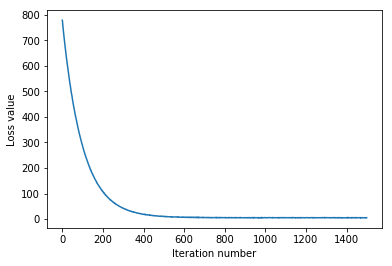

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.371163
validation accuracy: 0.368000


In [27]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e5]
#regularization_strengths =[(j+0.1*i)*1e4 for j in range(1,5) for i in range(0,10)]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
#print(X_val.shape)
#print(y_val.shape)
iters_num = 1500
val_acc_array=[]
svm_obj_array=[]
for lrs  in learning_rates:
  for regs in regularization_strengths:

    svm = LinearSVM()
    svm_obj_array.append(svm)
    loss_hist = svm.train(X_train, y_train, learning_rate=lrs, reg=regs ,
                      num_iters=iters_num , verbose=True)

    y_train_pred = svm.predict(X_train)
    ta = np.mean(y_train == y_train_pred)
    print 'training accuracy: %f' % (ta, ) 
    va = np.mean(y_val == y_val_pred)
    y_val_pred = svm.predict(X_val)
    print 'validation accuracy: %f' % (va, ) 

    results[(learning_rates[0],regs)] = (ta, va)
    val_acc_array.append(va)

best_val = max(val_acc_array)  
best_svm = svm_obj_array.pop(val_acc_array.index(max(val_acc_array)))
print(val_acc_array.index(max(val_acc_array)))


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
  
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 784.954191
iteration 100 / 1500: loss 287.127597
iteration 200 / 1500: loss 107.589829
iteration 300 / 1500: loss 42.105733
iteration 400 / 1500: loss 19.149444
iteration 500 / 1500: loss 10.413509
iteration 600 / 1500: loss 6.897709
iteration 700 / 1500: loss 6.108194
iteration 800 / 1500: loss 5.445702
iteration 900 / 1500: loss 5.746475
iteration 1000 / 1500: loss 4.728613
iteration 1100 / 1500: loss 4.629077
iteration 1200 / 1500: loss 5.199863
iteration 1300 / 1500: loss 4.983457
iteration 1400 / 1500: loss 5.408739
training accuracy: 0.367612
validation accuracy: 0.360000
iteration 0 / 1500: loss 1580.192087
iteration 100 / 1500: loss 213.854884
iteration 200 / 1500: loss 33.385261
iteration 300 / 1500: loss 9.076766
iteration 400 / 1500: loss 5.615795
iteration 500 / 1500: loss 5.301394
iteration 600 / 1500: loss 5.909415
iteration 700 / 1500: loss 5.654612
iteration 800 / 1500: loss 5.452700
iteration 900 / 1500: loss 5.864186
iteration 1000 / 1500: los

cs231n/classifiers/linear_svm.py:111: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)
/home/scott/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
cs231n/classifiers/linear_svm.py:111: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf


KeyboardInterrupt: 

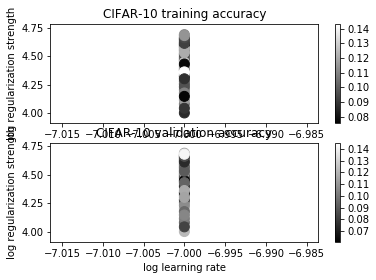

In [26]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [27]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.106000


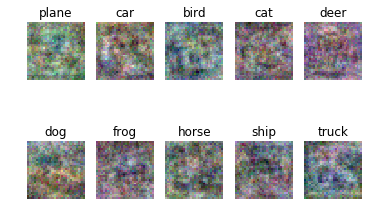

In [28]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*